# Исследование линейной регрессии 


## Цель проекта
Научиться предсказывать вес руды (в тоннах/час) на конвейере, по производительности 3 питателей с использованием линейной регрессии .

## Что такое Линейная регрессия?

Линейная регрессия (Linear Regression) — это один из методов машинного обучения, используемый для прогнозирования непрерывной величины на основе одной или нескольких входных переменных (признаков).

Она предполагает, что между входными признаками и целевой переменной существует линейная связь, которую можно выразить формулой:

```
вес = w1 * питатель1(%) + w2 * питатель2(%) + w3 * питатель3(%) + смещение (bias)
```
Цель линейной регрессии — найти такие коэффициенты (w1, w2, w3, bias) чтобы **разница между предсказанными и реальными значениями** была минимальной.

In [34]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

import os
import gdown

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### 1. Загрузка данных из Excel таблицы

In [ ]:
# Загружаем данные из Excel файла
# file_path = 'feders_weight.xlsx'
file_path = 'ЗИФ1 Производительность питателей.xlsx'
df = pd.read_excel(file_path, skiprows=4)

# Проверяем, существует ли файл локально (для щапуска блокнота в google colab)
if not os.path.exists(file_path):
    print("📂 Файл не найден. Скачиваю с Google Таблиц...")
    # Ссылка: https://docs.google.com/spreadsheets/d/1CJRtYXy3DoYjz3tphNro6BxYtK6tgyW8/edit...
    # ID файла: 1CJRtYXy3DoYjz3tphNro6BxYtK6tgyW8
    file_id = "1CJRtYXy3DoYjz3tphNro6BxYtK6tgyW8"
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)
    print(f"✅ Файл '{file_path}' успешно скачан.")
else:
    print(f"✅ Файл '{file_path}' найден локально.")

# Попробуем загрузить, если возникнет ошибка, сообщим
try:
    df = pd.read_excel(file_path, skiprows=4)
except Exception as e:
    print(f"❌ Ошибка при чтении файла: {e}")
    print("💡 Убедитесь, что файл является действительным .xlsx и имеет правильную структуру.")
    raise # Перебрасываем исключение, чтобы остановить выполнение ноутбука



✅ Файл 'ЗИФ1 Производительность питателей.xlsx' найден локально.


In [ ]:
# Переименовываем столбцы для удобства
# df.columns = [
#     'Time',
#     'Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent',
#     'Feeder1_Current', 'Feeder2_Current', 'Feeder3_Current',
#     'Weight_t_h'
# ]

df.columns = [
    'Time',
    'Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent',
    'Weight_t_h'
]


# Преобразуем запятые в точки и тип данных
df = df.replace(',', '.', regex=True)
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Удаляем строки с пропущенными значениями
df = df.dropna().reset_index(drop=True)

In [40]:
# Задайте желаемый диапазон дат
start_date = pd.to_datetime('2025-08-16 00:00:00')
end_date = pd.to_datetime('2025-08-22 00:00:00')

# Убедимся, что столбец 'Time' тоже имеет тип datetime (обычно уже так, но на всякий случай)
# Если df['Time'] уже datetime64[ns], это не повредит
df['Time'] = pd.to_datetime(df['Time'])

# Фильтруем DataFrame
df_filtered = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)].copy() # 
df = df_filtered

print("📊 Размерность данных:", df.shape)
print("\n📋 Первые 5 строк данных:")
df.head()

📊 Размерность данных: (4176, 5)

📋 Первые 5 строк данных:


,Time,Feeder1_Percent,Feeder2_Percent,Feeder3_Percent,Weight_t_h
35691,2025-08-16 00:00:00,0.0,0.0,0.0,0.54
35692,2025-08-16 00:02:00,0.0,0.0,0.0,0.55
35693,2025-08-16 00:04:00,0.0,0.0,0.0,0.57
35694,2025-08-16 00:06:00,0.0,0.0,0.0,0.50
35695,2025-08-16 00:08:00,0.0,0.0,0.0,0.59


## 2. Гистограмма для каждого параметра

Показывает распределение. Помогает понять:
- Как часто встречаются те или иные значения.
- Где сосредоточены данные (среднее, медиана).
- Есть ли перекос (асимметрия) в данных.
- Насколько велико рассеяние значений.
- Где находятся выбросы.

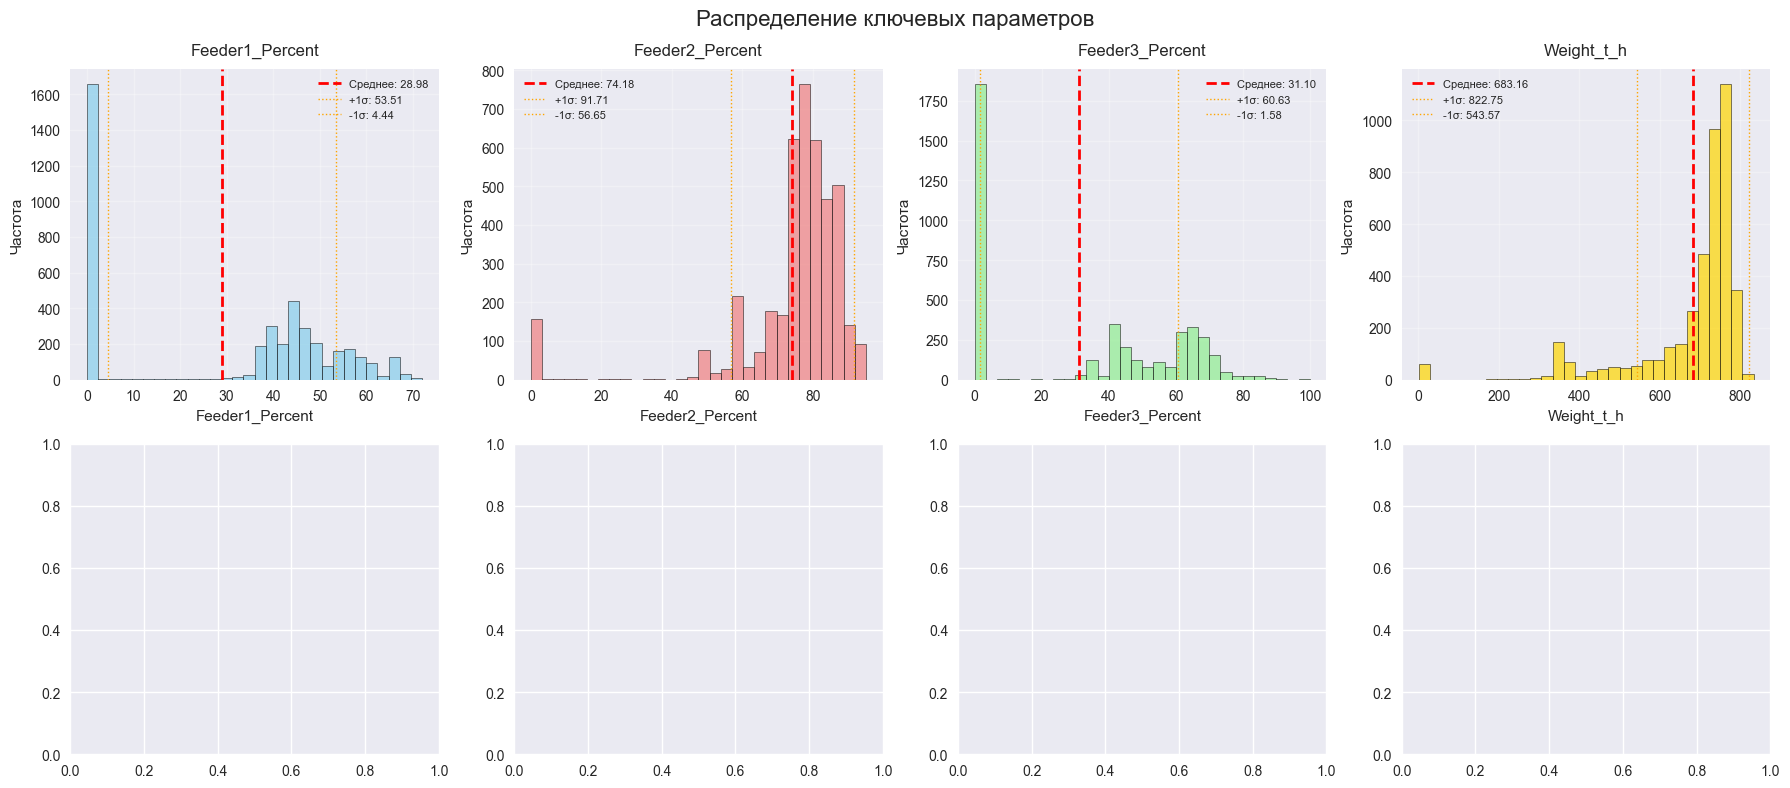

In [41]:
# Определяем ключевые параметры
# key_parameters = [
#     'Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent',
#     'Feeder1_Current', 'Feeder2_Current', 'Feeder3_Current',
#     'Weight_t_h'
# ]

key_parameters = [
    'Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent',
    'Weight_t_h'
]

# Создаем подробные гистограммы для каждого параметра
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Распределение ключевых параметров', fontsize=16, y=0.98)

# Цветовая палитра для разных параметров
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'orange', 'lightsteelblue']

for i, param in enumerate(key_parameters):
    row = i // 4
    col = i % 4
    
    # Гистограмма
    axes[row, col].hist(df[param], bins=30, alpha=0.7, color=colors[i], edgecolor='black', linewidth=0.5)
    axes[row, col].set_title(f'{param}', fontsize=12, pad=10)
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel('Частота')
    axes[row, col].grid(True, alpha=0.3)
    
    # Добавляем статистику на график
    mean_val = df[param].mean()
    std_val = df[param].std()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                          label=f'Среднее: {mean_val:.2f}')
    axes[row, col].axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1, 
                          label=f'+1σ: {mean_val + std_val:.2f}')
    axes[row, col].axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1, 
                          label=f'-1σ: {mean_val - std_val:.2f}')
    axes[row, col].legend(fontsize=8)

# Убираем пустую ячейку
# axes[2, 1].remove()
# axes[2, 2].remove()

plt.tight_layout()
plt.show()

## 3. Статистический анализ ключевых параметров
**Descriptive Statistics**  — **ключевая часть разведочного анализа данных (EDA)**. Его цель — **понять, как ведут себя ключевые параметры процесса** (производительность питателей и вес руды) с помощью **основных статистических показателей**.

|   |   | Что означает |
|------------------|------------------------|-------------|
| **Среднее** | **Mean** | Среднее арифметическое значение. Показывает "центр" данных. |
| **Медиана** | **Median** | Значение, которое делит упорядоченные данные пополам. Устойчива к выбросам. |
| **Стандартное отклонение** | **Standard Deviation (Std)** | Мера разброса данных вокруг среднего. Чем больше — тем сильнее вариация. |
| **Минимум / Максимум** | **Minimum / Maximum** | Крайние значения в выборке. Помогают оценить диапазон. |
| **25% и 75% перцентили** | **25th and 75th Percentiles** | Границы нижней и верхней четверти данных. Вместе с медианой формируют **интерквартильный размах (IQR)**. |
| **Коэффициент вариации** | **Coefficient of Variation (CV)** | Отношение стандартного отклонения к среднему (в процентах). Показывает **относительную изменчивость**. |

#### Пример интерпретации

> **Feeder2_Percent** — самый стабильный питатель: работает в узком диапазоне (73–83% в 50% случаев), среднее и медиана близки, низкое стандартное отклонение. Это означает, что он, скорее всего, работает **в постоянном режиме** и вносит **предсказуемый вклад** в общий вес.

> **Feeder1_Percent** — часто простаивает (минимум = 0, 25%-квантиль = 0), но может работать до 72%. Высокий разброс — значит, его влияние на выход **нестабильно**.


In [42]:
# Подробная статистика для ключевых параметров
print("📊 Подробная статистика ключевых параметров:")
print("=" * 80)

stats_data = []
for param in key_parameters:
    stats = {
        'Параметр': param,
        'Среднее': df[param].mean(),
        'Медиана': df[param].median(),
        'Станд. отклонение': df[param].std(),
        'Минимум': df[param].min(),
        'Максимум': df[param].max(),
        '25%': df[param].quantile(0.25),
        '75%': df[param].quantile(0.75),
        'Коэф. вариации (%)': (df[param].std() / df[param].mean()) * 100
    }
    stats_data.append(stats)

stats_df = pd.DataFrame(stats_data)
print(stats_df.round(2).to_string(index=False))

📊 Подробная статистика ключевых параметров:
       Параметр  Среднее  Медиана  Станд. отклонение  Минимум  Максимум    25%    75%  Коэф. вариации (%)
Feeder1_Percent    28.98    40.00              24.54     0.00     72.00   0.00  47.17               84.69
Feeder2_Percent    74.18    78.00              17.53     0.00     95.00  73.05  83.09               23.63
Feeder3_Percent    31.10    40.00              29.53     0.00    100.00   0.00  62.00               94.92
     Weight_t_h   683.16   735.01             139.59     0.28    833.43 677.46 760.31               20.43


## 4. Boxplot (ящик с усами)
**Boxplot**, или **ящик с усами (box-and-whisker plot)** — это графический способ визуализации **распределения данных** через их **квантили**. Он позволяет быстро оценить центральную тенденцию, разброс, асимметрию и наличие **выбросов (outliers)**.

Каждый ящик (box) и «усы» (whiskers) показывают ключевые статистические характеристики:

| Элемент графика | Русское название | Английское название | Что означает |
|-----------------|------------------|------------------------|-------------|
| 🟦 Центр ящика | **Медиана** | **Median (Q2 / 50th percentile)** | Значение, которое делит выборку пополам: 50% данных ниже, 50% — выше. |
| 📦 Границы ящика | **25-й и 75-й перцентили** | **First Quartile (Q1), Third Quartile (Q3)** | Внутри ящика находится **50% всех данных**. |
| 📏 Ширина ящика | **Интерквартильный размах** | **Interquartile Range (IQR = Q3 - Q1)** | Мера разброса **средней половины** данных. |
| 📏 «Усы» (линии) | **Внутренние границы** | **Whiskers** | Обычно простираются до значений: `Q1 - 1.5×IQR` и `Q3 + 1.5×IQR`. |
| ⚫ Точки за усами | **Выбросы** | **Outliers** | Значения, выходящие за пределы усов — потенциально аномальные наблюдения. |

---

#### Пример интерпретации

> **Feeder2_Percent**:
> - Узкий ящик → **стабильная загрузка**.
> - Медиана около 78% → работает на высокой мощности.
> - Несколько выбросов внизу → **кратковременные снижения** (возможно, регулировка).
>
> **Feeder3_Percent**:
> - Очень широкий ящик → **сильный разброс**.
> - Медиана 40%, но максимум — 100% → работает в режиме **вкл/выкл**.
> - Много выбросов вверху → возможны **пиковые нагрузки**.
>
> **Weight_t_h**:
> - Ящик узкий, медиана 735 т/ч → **стабильный поток**.
> - Выбросы внизу (близко к 0) — **потенциально ошибочные измерения** или остановки.

---


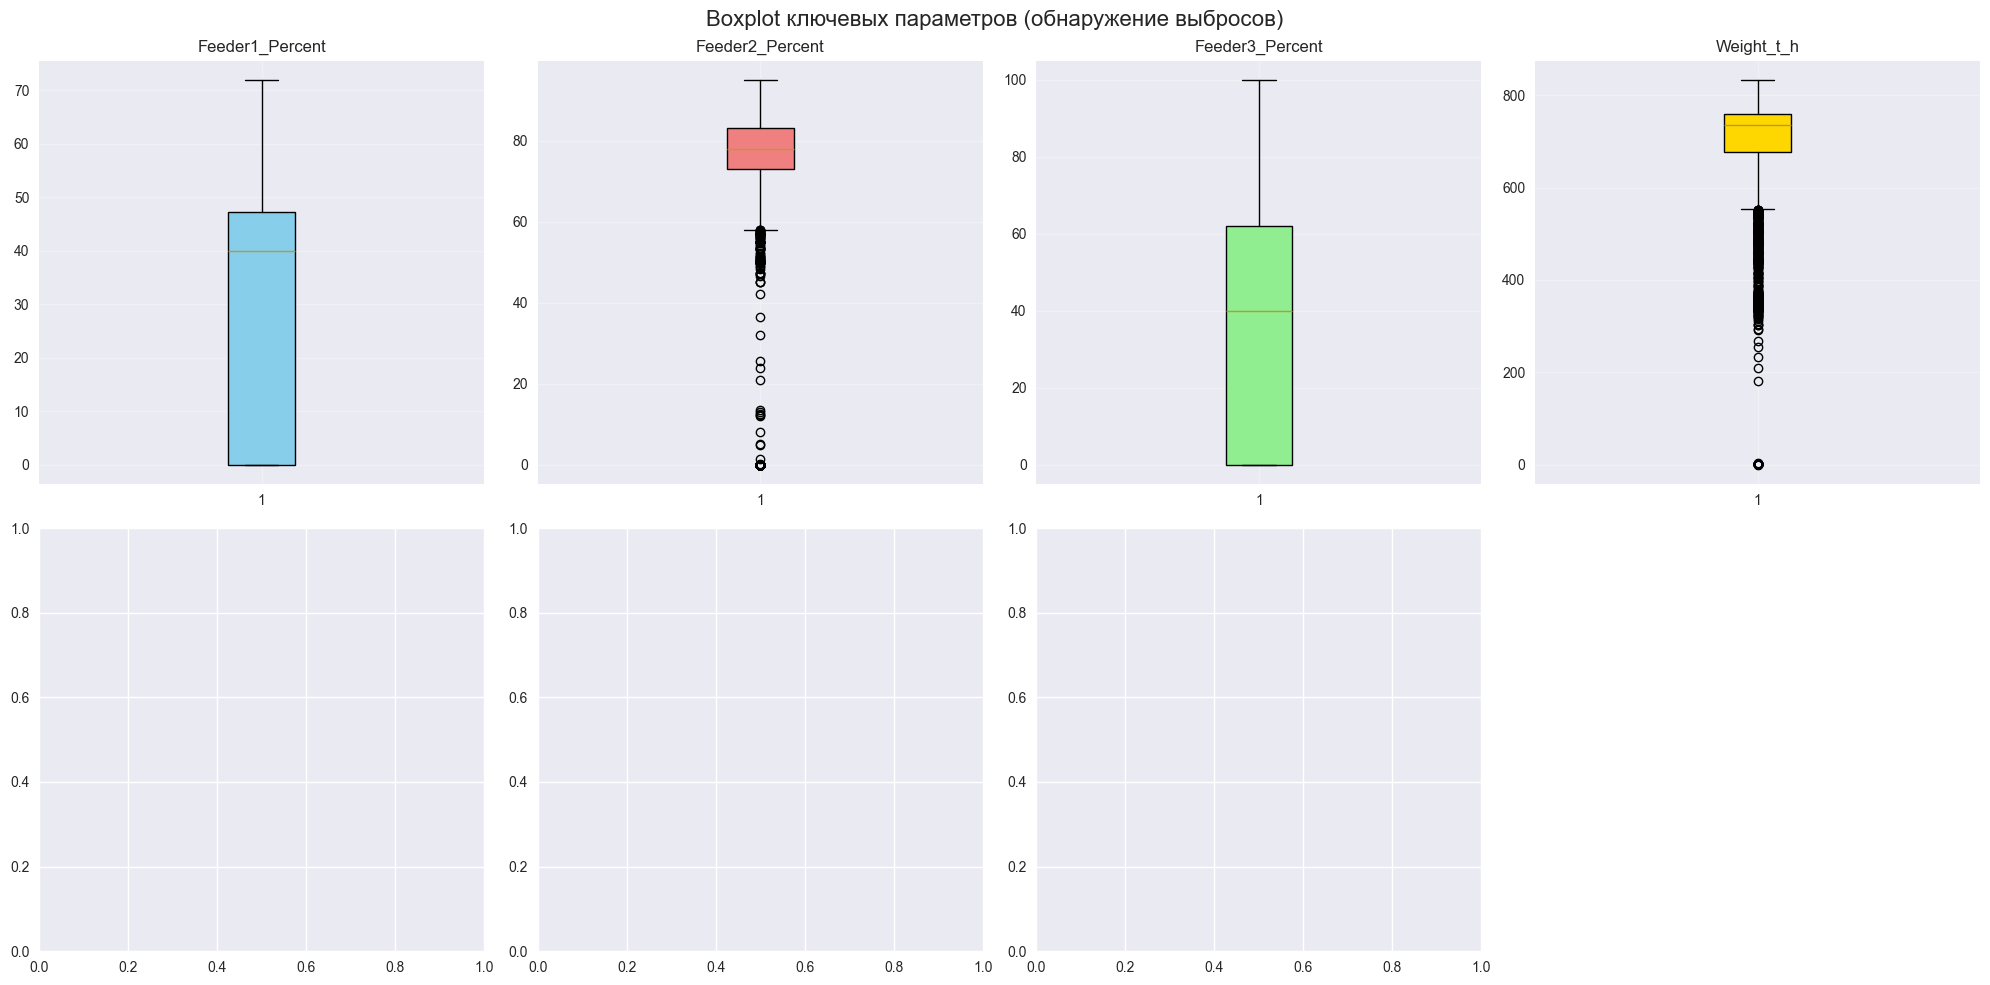

In [43]:
# Boxplot для визуализации распределения и выбросов
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Boxplot ключевых параметров (обнаружение выбросов)', fontsize=16)

for i, param in enumerate(key_parameters):
    row = i // 4
    col = i % 4
    box_plot = axes[row, col].boxplot(df[param], patch_artist=True)
    box_plot['boxes'][0].set_facecolor(colors[i])
    axes[row, col].set_title(f'{param}')
    axes[row, col].grid(True, alpha=0.3)

# Убираем пустые ячейки
axes[1, 3].remove()

plt.tight_layout()
plt.show()

## 5. Добавление скользящих средних 
**Moving Average, MA** — это статистическая техника сглаживания временных рядов. Она заменяет каждое значение в последовательности **средним значением** нескольких предыдущих точек (включая текущую), что позволяет:
- Уменьшить **шум (noise)** и **случайные колебания**.
- Выявить **основной тренд (trend)** процесса.
- Сделать данные более устойчивыми к кратковременным выбросам.


In [44]:
# Функция для добавления скользящих средних
def add_moving_averages(df, window=5):
    df_with_ma = df.copy()
    
    # Числовые столбцы (все кроме Time)
    numeric_columns = df.columns[1:]
    
    # Добавляем скользящие средние для каждого числового параметра
    for col in numeric_columns:
        ma_column_name = f'{col}_MA_{window}'
        df_with_ma[ma_column_name] = df_with_ma[col].rolling(window=window, min_periods=1).mean()
    
    return df_with_ma

# Добавляем скользящие средние с разными окнами
df_with_ma_3 = add_moving_averages(df, window=3)   # 3-периодное скользящее среднее
df_with_ma_5 = add_moving_averages(df, window=5)   # 5-периодное скользящее среднее
df_with_ma_10 = add_moving_averages(df, window=10) # 10-периодное скользящее среднее

# Для дальнейшего анализа используем 5-периодное скользящее среднее
df = df_with_ma_3

print("📊 Размерность данных после добавления скользящих средних:", df.shape)
print("\n📋 Первые 10 строк данных с скользящими средними:")
df.head(5)

📊 Размерность данных после добавления скользящих средних: (4176, 9)

📋 Первые 10 строк данных с скользящими средними:


,Time,Feeder1_Percent,Feeder2_Percent,Feeder3_Percent,Weight_t_h,Feeder1_Percent_MA_3,Feeder2_Percent_MA_3,Feeder3_Percent_MA_3,Weight_t_h_MA_3
35691,2025-08-16 00:00:00,0.0,0.0,0.0,0.54,0.0,0.0,0.0,0.540000
35692,2025-08-16 00:02:00,0.0,0.0,0.0,0.55,0.0,0.0,0.0,0.545000
35693,2025-08-16 00:04:00,0.0,0.0,0.0,0.57,0.0,0.0,0.0,0.553333
35694,2025-08-16 00:06:00,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.540000
35695,2025-08-16 00:08:00,0.0,0.0,0.0,0.59,0.0,0.0,0.0,0.553333


## 6. Сравнение исходных данных и скользящих средних

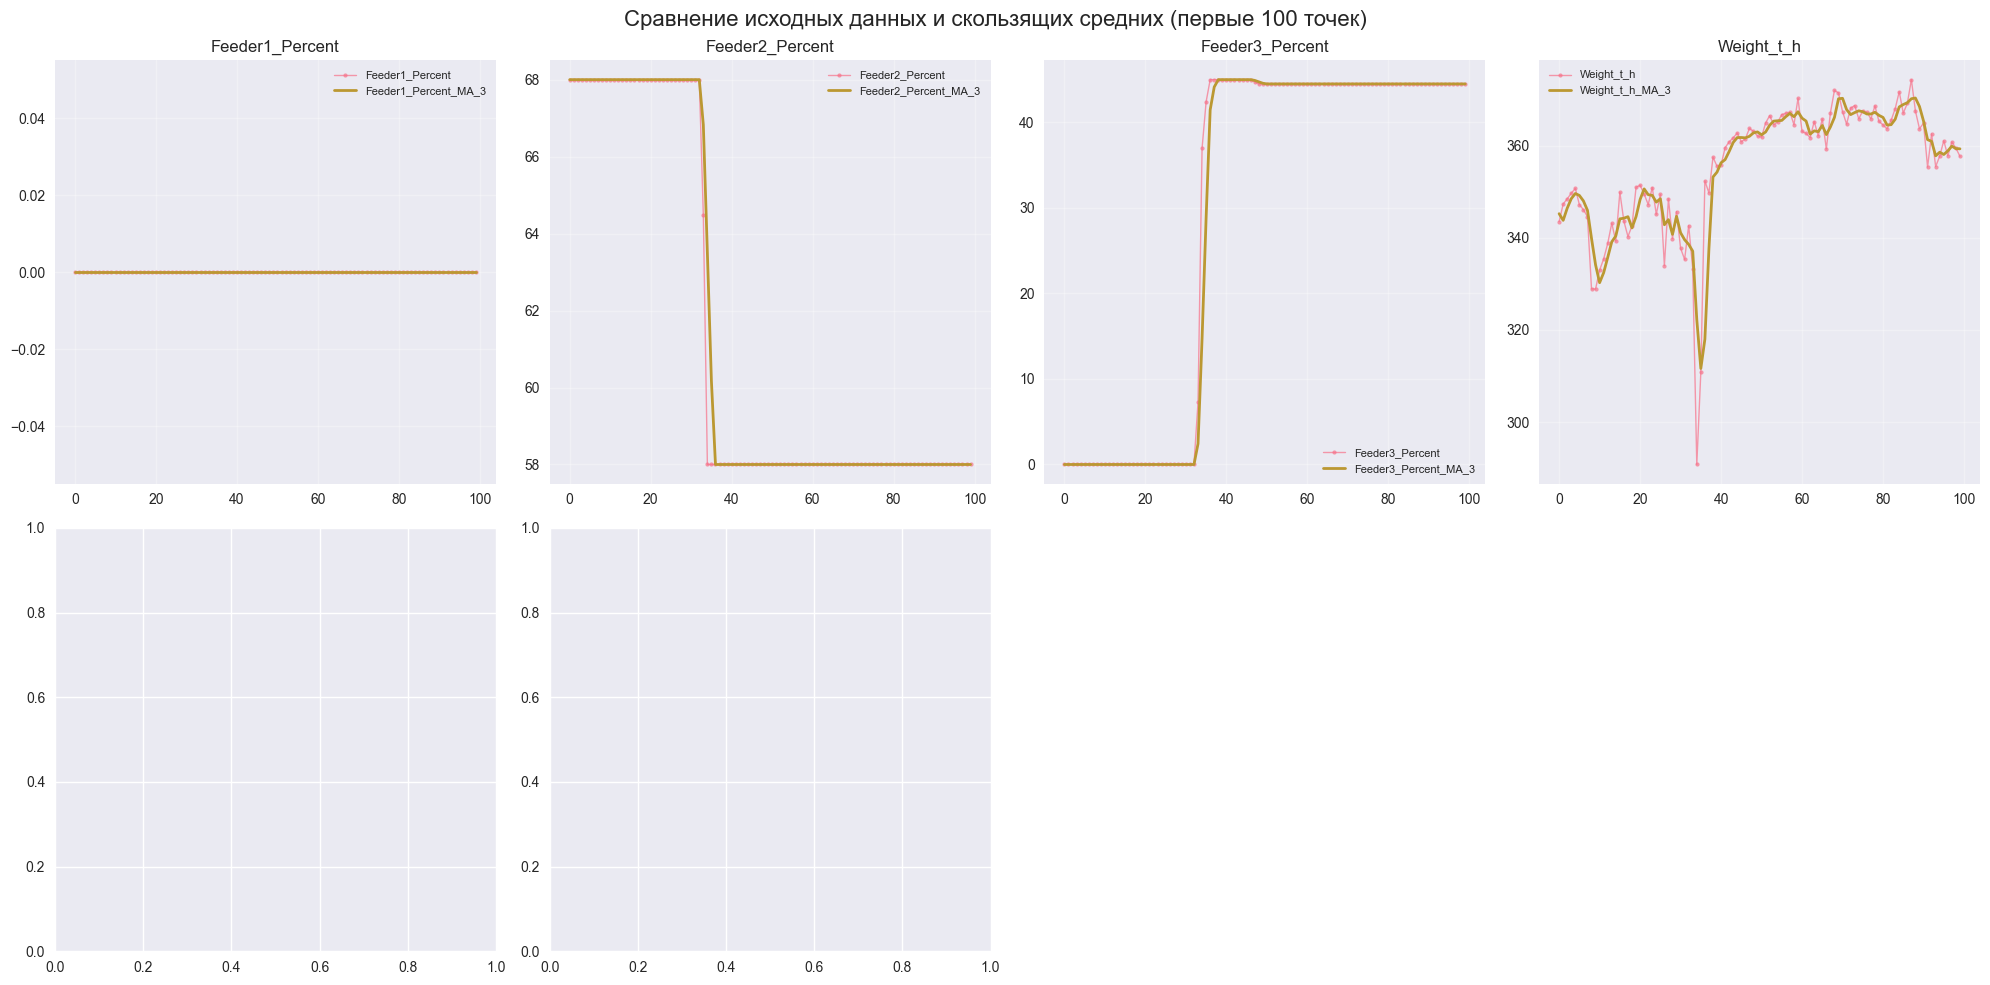

In [45]:
# Визуализация исходных данных и скользящих средних для всех ключевых параметров
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Сравнение исходных данных и скользящих средних (первые 100 точек)', fontsize=16)

for i, param in enumerate(key_parameters):
    row = i // 4
    col = i % 4
    ma_param = f'{param}_MA_3'
    
    # Ограничиваем данные для лучшей визуализации
    x_range = range(min(100, len(df)))
    
    axes[row, col].plot(x_range, df[param].iloc[100:200], 'o-', 
                       label=param, alpha=0.7, markersize=3, linewidth=1)
    axes[row, col].plot(x_range, df[ma_param].iloc[100:200], '-', 
                       label=ma_param, linewidth=2)
    axes[row, col].set_title(f'{param}', fontsize=12)
    axes[row, col].legend(fontsize=8)
    axes[row, col].grid(True, alpha=0.3)

# Убираем пустые ячейки
axes[1, 2].remove()
axes[1, 3].remove()

plt.tight_layout()
plt.show()

## 7. Обнаружение выбросов
### 🚩 Что такое выбросы (outliers)?

**Выбросы (outliers)** — это значения в данных, которые **сильно отличаются** от остальных наблюдений. Они могут быть вызваны:

- Ошибками измерения (например, сбой датчика).
- Аномальными условиями работы оборудования.
- Редкими, но реальными событиями (например, пуск или остановка установки).

В контексте проекта по предсказанию веса руды (`Weight_t_h`) по загрузке питателей, выбросы могут:

- Искажать обучение модели.
- Увеличивать ошибку предсказания.
- Приводить к неверным выводам о работе оборудования.

Поэтому **обнаружение выбросов (outlier detection)** — критически важный этап перед построением модели.

---

### 🔍 Какие методы используются для обнаружения выбросов?

В этом проекте применяются **два основных статистических подхода**:

---

#### 1. **Метод Z-оценки (Z-score method)**

**Z-оценка (Z-score)** — это мера того, **на сколько стандартных отклонений** значение отстоит от среднего.

> 📌 Формула:  
> \[
> z = \frac{x - \mu}{\sigma}
> \]
> где:
> - \(x\) — значение признака,
> - \(\mu\) — среднее (mean),
> - \(\sigma\) — стандартное отклонение (standard deviation).

**Правило:**
- Если \(|z| > 3\), значение считается **выбросом**.
- Это основано на **правиле трёх сигм (68-95-99.7 rule)** для нормального распределения: 99.7% значений лежат в пределах ±3σ от среднего.

**Английские термины:**
- **Z-score** — стандартная оценка.
- **Threshold = 3** — пороговое значение.
- **Normal distribution assumption** — предположение о нормальности распределения.

**Пример из проекта:**
- У `Feeder2_Percent` обнаружено **166 выбросов** по z-score.
- Это может означать, что питатель редко, но резко снижает или повышает загрузку (например, при регулировке).

---

#### 2. **Метод перцентилей (Percentile method)**

Этот метод **не предполагает нормальности** распределения. Он использует **квантили (quantiles)** для определения границ "нормальных" значений.

**Как работает:**
- Задаётся диапазон, например, **от 5-го до 95-го перцентиля**.
- Все значения **ниже 5%** или **выше 95%** считаются выбросами.

**Английские термины:**
- **Percentile / Quantile** — перцентиль / квантиль.
- **Interquartile Range (IQR)** — интерквартильный размах (часто используется с 25% и 75%).
- **Whiskers in boxplot** — усы в ящике с усами, основанные на IQR.
- **Robust to distribution shape** — устойчив к форме распределения.

**Пример из проекта:**
- У `Weight_t_h` обнаружено **418 выбросов** по перцентилям.
- Это может быть связано с:
  - Очень низким весом (близко к 0 т/ч) — конвейер почти пуст.
  - Очень высоким весом (близко к 833 т/ч) — пиковая нагрузка.

---

### 🧠 Зачем использовать два метода?

| Метод | Плюсы ✅ | Минусы ❌ |
|------|--------|--------|
| **Z-score** | Чёткое статистическое обоснование (если данные нормальны). | Чувствителен к перекосу (skewness). Не работает при асимметричных распределениях. |
| **Percentile** | Универсален, не зависит от формы распределения. | Может удалить **реальные, но редкие** события (например, пиковые нагрузки). |

Использование **обоих методов** позволяет:
- Получить **разные взгляды** на данные.
- Сравнить результаты.
- Принять взвешенное решение при **очистке данных (data cleaning)**.

---

### 📊 Интерпретация результатов

Проект показывает:

```
🔍 Выбросы для ключевых параметров:
По z-score (порог = 3):
  Feeder1_Percent: 0 выбросов
  Feeder2_Percent: 166 выбросов
  Feeder3_Percent: 0 выбросов
  Weight_t_h: 65 выбросов

По перцентилям (0.05 - 0.95):
  Feeder1_Percent: 209 выбросов
  Feeder2_Percent: 394 выбросов
  Feeder3_Percent: 183 выбросов
  Weight_t_h: 418 выбросов
```

**Что это значит?**

- **Feeder1_Percent и Feeder3_Percent** имеют много нулей (простои), но при этом **не выходят за 3σ**, потому что среднее и стандартное отклонение уже учитывают эти нули.
- **Feeder2_Percent** работает стабильно (высокое среднее, низкий разброс), но **166 раз** отклонился слишком сильно — возможно, кратковременные остановки.
- **Weight_t_h** имеет много выбросов по перцентилям — это нормально, так как вес может резко меняться при запуске/остановке.

---

#### ✅ Почему это важно?

1. **Качество модели (Model Performance)**  
   Выбросы могут "перетянуть" линию регрессии, заставив модель **плохо работать на нормальных данных**.

2. **Интерпретируемость (Interpretability)**  
   Если модель обучена на данных с аномалиями, её коэффициенты могут быть **искажены**.

3. **Надёжность прогнозов (Prediction Reliability)**  
   Удаление выбросов помогает построить **более устойчивую и обобщающую модель**.

---

#### 📝 Вывод

**Обнаружение выбросов** — это ключевой этап **разведочного анализа данных (Exploratory Data Analysis, EDA)**. Он позволяет:

- Выявить аномалии в работе оборудования.
- Оценить качество данных.
- Подготовить данные к обучению модели.

Использование **двух методов — Z-score и Percentile** — даёт полную картину:
- **Z-score** — для статистически обоснованного подхода.
- **Percentile** — для гибкого, устойчивого к форме распределения анализа.

На следующем шаге (**очистка данных**) эти выбросы будут **удалены**, чтобы модель обучалась на **репрезентативной выборке**.

In [46]:
# Определяем все числовые столбцы (включая скользящие средние)
numeric_columns = df.columns[1:]

# Функция для обнаружения выбросов по z-score
def detect_outliers_zscore(data, columns, threshold=3):
    """Обнаруживает выбросы по z-score"""
    outliers_info = {}
    for col in columns:
        z_scores = np.abs((data[col] - data[col].mean()) / data[col].std())
        outliers = data[z_scores > threshold]
        outliers_info[col] = len(outliers)
    return outliers_info

# Функция для обнаружения выбросов по перцентилям
def detect_outliers_percentile(data, columns, low=0.05, high=0.95):
    """Обнаруживает выбросы по перцентилям"""
    outliers_info = {}
    for col in columns:
        lower = data[col].quantile(low)
        upper = data[col].quantile(high)
        outliers = data[(data[col] < lower) | (data[col] > upper)]
        outliers_info[col] = len(outliers)
    return outliers_info

# Обнаружение выбросов для ключевых параметров
print("🔍 Выбросы для ключевых параметров:")
print("=" * 60)
print("По z-score (порог = 3):")
zscore_outliers = detect_outliers_zscore(df, key_parameters, 3)
for param in key_parameters:
    count = zscore_outliers.get(param, 0)
    print(f"  {param}: {count} выбросов")

print("\nПо перцентилям (0.05 - 0.95):")
percentile_outliers = detect_outliers_percentile(df, key_parameters, 0.05, 0.95)
for param in key_parameters:
    count = percentile_outliers.get(param, 0)
    print(f"  {param}: {count} выбросов")

🔍 Выбросы для ключевых параметров:
По z-score (порог = 3):
  Feeder1_Percent: 0 выбросов
  Feeder2_Percent: 166 выбросов
  Feeder3_Percent: 0 выбросов
  Weight_t_h: 65 выбросов

По перцентилям (0.05 - 0.95):
  Feeder1_Percent: 209 выбросов
  Feeder2_Percent: 394 выбросов
  Feeder3_Percent: 183 выбросов
  Weight_t_h: 418 выбросов


## 8. Очистка данных от выбросов
### 🧹 Что такое очистка данных от выбросов?

**Очистка данных от выбросов (Outlier Removal / Data Cleaning)** — это процесс **удаления или корректировки аномальных значений** из набора данных, которые могут искажать анализ или обучение модели.

Цель — получить **более репрезентативную и стабильную выборку**, на которой модель машинного обучения сможет обучиться **реальным закономерностям**, а не шуму или ошибкам.

---

### 🔍 Почему это важно?

Выбросы — это как "аномалии" в данных:
- Они могут быть вызваны **ошибками датчиков**, **сбоями оборудования** или **редкими, но реальными событиями**.
- Даже несколько выбросов могут **сильно повлиять** на модель линейной регрессии, так как она чувствительна к экстремальным значениям.

Без очистки модель может:
- **Переобучиться** на аномалиях.
- Иметь **заниженную точность** на нормальных данных.
- Выдавать **нестабильные коэффициенты**.

Поэтому **очистка данных** — обязательный шаг перед обучением модели.

---

### 🛠️ Какие методы используются?

В этом проекте применяются **два подхода к удалению выбросов**, основанные на результатах предыдущего этапа **"Обнаружение выбросов"**:

#### 1. **Удаление по перцентилям (Percentile-based Removal)**

- Удаляются значения, выходящие за пределы **5-го и 95-го перцентиля**.
- То есть удаляются **5% самых низких** и **5% самых высоких** значений.

🔹 **Английские термины:**
- **Percentile filtering** — фильтрация по перцентилям.
- **Top 5% / Bottom 5%** — верхние и нижние 5%.
- **Robust to distribution shape** — устойчив к форме распределения.

✅ **Плюсы:**
- Не требует предположения о нормальности распределения.
- Универсален и прост в интерпретации.

❌ **Минусы:**
- Может удалить **реальные, но редкие** события (например, пиковые нагрузки).

---

#### 2. **Удаление по Z-оценке (Z-score-based Removal)**

- Удаляются значения, у которых **|z-score| > 3**, то есть те, что находятся дальше **3 стандартных отклонений** от среднего.

🔹 **Английские термины:**
- **Z-score thresholding** — пороговая фильтрация по Z-оценке.
- **Standard deviation (σ)** — стандартное отклонение.
- **3-sigma rule** — правило трёх сигм (в нормальном распределении 99.7% данных лежат в пределах ±3σ).

✅ **Плюсы:**
- Статистически обоснованный подход.
- Хорошо работает, если данные близки к нормальному распределению.

❌ **Минусы:**
- Чувствителен к **асимметрии (skewness)** и **ненормальности** распределения.
- Может не сработать, если среднее и дисперсия искажены самими выбросами.

---

### 📊 Как это применяется в проекте?

Проект последовательно:
1. **Сначала удаляет выбросы по перцентилям** — это убирает крайние значения.
2. **Затем применяет Z-score** — это "доочищает" данные от оставшихся аномалий.

Результат:
```
🧹 Очистка данных:
Исходное количество строк: 4176
Удалено 1026 строк (24.6%) по перцентилям
Удалено 167 строк (4.0%) по z-score
Финальное количество строк: 4009
```

---

### 🧠 Что происходит с данными?

После очистки:
- **Распределения становятся более "чистыми"** — меньше хвостов и аномальных пиков.
- **Модель становится устойчивее** — её коэффициенты меньше "дергаются" из-за редких всплесков.
- **Качество предсказаний улучшается** — особенно на тестовой выборке.

---

### ✅ Почему не удалять все выбросы сразу?

Потому что:
- **Разные методы ловят разные типы аномалий.**
- Удаление по перцентилям — **грубая очистка**.
- Удаление по Z-score — **тонкая донастройка**.
- Такой **двухэтапный подход** даёт более сбалансированный результат.

---

### 📝 Вывод

**Очистка данных от выбросов** — это **ключевой этап подготовки данных (Data Preprocessing)** в машинном обучении.

Она позволяет:
- Повысить **надёжность и точность модели**.
- Уменьшить влияние **шума и ошибок измерения**.
- Сделать результаты анализа **более интерпретируемыми**.

На английском это называется **"Outlier Removal"** или **"Data Filtering"**, и это стандартная практика в **Exploratory Data Analysis (EDA)** и **Predictive Modeling**.

В данном проекте очистка помогает построить **более точную и устойчивую модель линейной регрессии** для предсказания веса руды.

In [47]:
# Функция удаления выбросов по перцентилям
def remove_outliers_percentile(data, columns, low=0.05, high=0.95):
    """Удаляет выбросы по перцентилям"""
    original_len = len(data)
    for col in columns:
        lower = data[col].quantile(low)
        upper = data[col].quantile(high)
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    data = data.reset_index(drop=True)
    removed = original_len - len(data)
    print(f"Удалено {removed} строк ({removed/original_len*100:.1f}%) по перцентилям")
    return data

# Функция удаления выбросов по z-score
def remove_outliers_zscore(data, columns, threshold=3):
    """Удаляет выбросы по z-score"""
    original_len = len(data)
    z_scores = np.abs((data[columns] - data[columns].mean()) / data[columns].std())
    data = data[(z_scores < threshold).all(axis=1)]
    data = data.reset_index(drop=True)
    removed = original_len - len(data)
    print(f"Удалено {removed} строк ({removed/original_len*100:.1f}%) по z-score")
    return data

# Последовательная очистка данных
print("🧹 Очистка данных:")
print(f"Исходное количество строк: {len(df)}")

# Удаление выбросов по перцентилям
df_no_percentile_outliers = remove_outliers_percentile(df.copy(), key_parameters, 0.05, 0.95)

# Удаление выбросов по z-score
# df_clean = remove_outliers_zscore(df_no_percentile_outliers, key_parameters, 3)
df_clean = remove_outliers_zscore(df.copy(), key_parameters, 3)



print(f"Финальное количество строк: {len(df_clean)}")

🧹 Очистка данных:
Исходное количество строк: 4176
Удалено 1026 строк (24.6%) по перцентилям
Удалено 167 строк (4.0%) по z-score
Финальное количество строк: 4009


### 9. Сравнение распределений до и после очистки

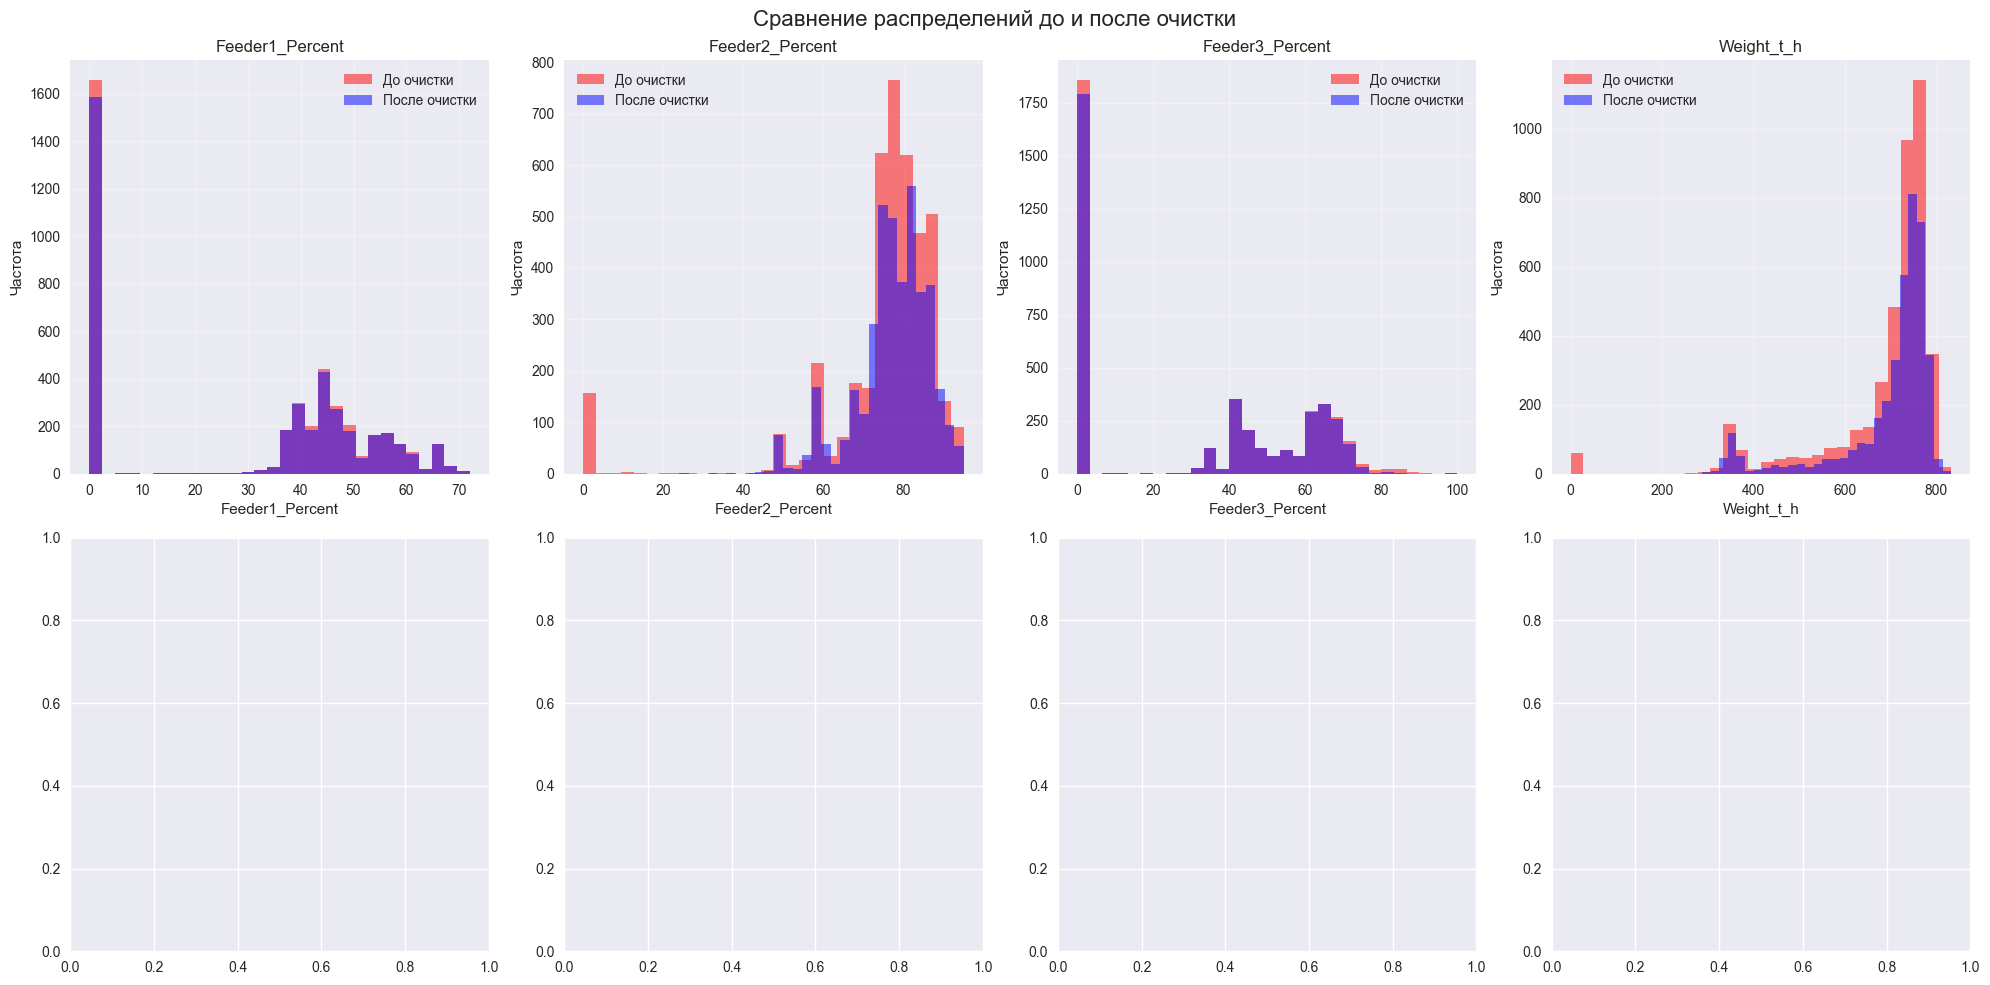

In [48]:
# Визуализация распределений до и после очистки для ключевых параметров
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Сравнение распределений до и после очистки', fontsize=16)

for i, param in enumerate(key_parameters):
    row = i // 4
    col = i % 4
    
    # До очистки
    axes[row, col].hist(df[param], bins=30, alpha=0.5, label='До очистки', color='red')
    # После очистки
    axes[row, col].hist(df_clean[param], bins=30, alpha=0.5, label='После очистки', color='blue')
    axes[row, col].set_title(f'{param}')
    axes[row, col].set_xlabel(param)
    axes[row, col].set_ylabel('Частота')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Убираем пустую ячейку
# axes[1, 3].remove()

plt.tight_layout()
plt.show()

### 10. Подготовка данных для моделирования

In [49]:
# Определяем входы и выход
# Используем исходные параметры + скользящие средние
# input_features = [
#     'Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent',
#     'Feeder1_Current', 'Feeder2_Current', 'Feeder3_Current'
# ]
input_features = [
    'Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent',
]


X = df_clean[input_features]
y = df_clean['Weight_t_h']

# X = df[input_features]
# y = df['Weight_t_h']

print("🎯 Входные признаки (X):")
print(X.columns.tolist())
print(f"\n📊 Количество признаков: {len(X.columns)}")
print("\n🎯 Первые 5 строк входных данных:")
X.head()

🎯 Входные признаки (X):
['Feeder1_Percent', 'Feeder2_Percent', 'Feeder3_Percent']

📊 Количество признаков: 3

🎯 Первые 5 строк входных данных:


,Feeder1_Percent,Feeder2_Percent,Feeder3_Percent
0,0.0,66.07,0.0
1,0.0,68.00,0.0
2,0.0,68.00,0.0
3,0.0,68.00,0.0
4,0.0,68.42,0.0


## 11. Корреляционный анализ
### 🔗 Что такое корреляционный анализ?

**Корреляционный анализ (Correlation Analysis)** — это статистический метод, который позволяет оценить **силу и направление линейной связи** между двумя или более переменными.

В контексте данного проекта он используется, чтобы понять:
- Как **загрузка каждого питателя** (`Feeder1_Percent`, `Feeder2_Percent`, `Feeder3_Percent`) связана с **весом руды на конвейере** (`Weight_t_h`).
- Есть ли сильная связь между самими питателями (например, работают ли они синхронно).

---

### 📊 Что показывает корреляционная матрица?

**Корреляционная матрица (Correlation Matrix)** — это таблица, в которой каждый элемент показывает **коэффициент корреляции Пирсона (Pearson Correlation Coefficient)** между двумя переменными.

#### 🔢 Значения коэффициента корреляции (r):
| Значение | Интерпретация | Английский термин |
|--------|--------------|-------------------|
| `r ≈ 1` | Сильная **положительная** линейная связь | **Strong positive correlation** |
| `r ≈ 0` | Нет линейной связи | **No linear correlation** |
| `r ≈ -1` | Сильная **отрицательная** линейная связь | **Strong negative correlation** |

> 🔎 **Важно:** корреляция ≠ причинность (correlation ≠ causation).  
> Даже если две переменные сильно коррелируют, это не значит, что одна **вызывает** другую.

---

### 🧠 Зачем нужен корреляционный анализ в этом проекте?

#### 1. **Оценка влияния питателей на вес руды**
- Мы хотим понять, **какой из питателей сильнее всего влияет** на `Weight_t_h`.
- Если, например, `Feeder2_Percent` имеет коэффициент корреляции **0.9**, это означает, что его загрузка **очень сильно** связана с увеличением веса — он, вероятно, является **основным источником подачи руды**.

#### 2. **Проверка мультиколлинеарности (Multicollinearity)**
- Если два питателя (например, `Feeder2_Percent` и `Feeder3_Percent`) сильно коррелируют друг с другом (например, `r = 0.85`), это может означать, что они **работают синхронно**.
- Это важно, потому что **сильная мультиколлинеарность** может затруднить интерпретацию коэффициентов модели линейной регрессии (например, один коэффициент может быть искусственно завышен, а другой — занижен).

#### 3. **Проверка разумности данных**
- Если `Feeder1_Percent` и `Weight_t_h` имеют корреляцию близкую к **0**, это может означать:
  - Питатель почти не работает.
  - Его работа не влияет на общий поток.
  - Или есть ошибка в измерениях.

---

### 📌 Пример интерпретации (гипотетические значения)

Предположим, матрица показывает:

| Пара | Коэффициент корреляции |
|------|------------------------|
| `Feeder2_Percent` ↔ `Weight_t_h` | **0.88** |
| `Feeder3_Percent` ↔ `Weight_t_h` | **0.52** |
| `Feeder1_Percent` ↔ `Weight_t_h` | **0.15** |
| `Feeder2_Percent` ↔ `Feeder3_Percent` | **0.65** |

**Что это значит?**

- ✅ **Feeder2_Percent** — **ключевой фактор**: его работа напрямую и сильно влияет на вес руды.
- ⚠️ **Feeder3_Percent** — **умеренное влияние**: вносит вклад, но не доминирует.
- ❌ **Feeder1_Percent** — **слабое влияние**: почти не связан с выходом, возможно, он редко используется.
- ⚠️ **Feeder2 и Feeder3 коррелируют на 0.65** — это указывает на **частичную синхронность** их работы, что может быть важно при интерпретации модели.

---

### 🎨 Визуализация: тепловая карта (Heatmap)

Проект использует **тепловую карту (Heatmap)** для визуализации матрицы корреляции:

- **Красные оттенки** — сильная положительная корреляция.
- **Синие оттенки** — слабая или отрицательная корреляция.
- **Белые/нейтральные** — отсутствие связи.

Это позволяет **быстро увидеть** самые важные связи "глазами".

---

### ✅ Почему это важно перед обучением модели?

1. **Отбор признаков (Feature Selection)**  
   Можно временно исключить признаки с очень слабой корреляцией (например, `Feeder1_Percent`), чтобы упростить модель.

2. **Интерпретация результатов**  
   Корреляция помогает понять, **ожидаемы ли коэффициенты модели**. Например, если `Feeder2` сильно коррелирует с `Weight_t_h`, мы ожидаем, что его коэффициент в модели будет **высоким и положительным**.

3. **Обнаружение аномалий**  
   Отрицательная корреляция между питателем и весом — это **красный флаг**, требующий проверки данных.

---

### 📝 Вывод

**Корреляционный анализ** — это **ключевой этап разведочного анализа данных (Exploratory Data Analysis, EDA)**. Он позволяет:

- Оценить **силу связи** между входами и выходом.
- Выявить **наиболее значимые признаки**.
- Обнаружить **проблемы в данных** (например, мультиколлинеарность).
- Принять обоснованные решения перед обучением модели.

На английском это называется **"Feature-Target Correlation Analysis"** или **"Bivariate Correlation Study"**, и это стандартная практика в машинном обучении и анализе промышленных процессов.

В данном проекте он подтверждает, что **Feeder2_Percent** — главный драйвер производительности, а **Feeder1_Percent** — наименее значимый.

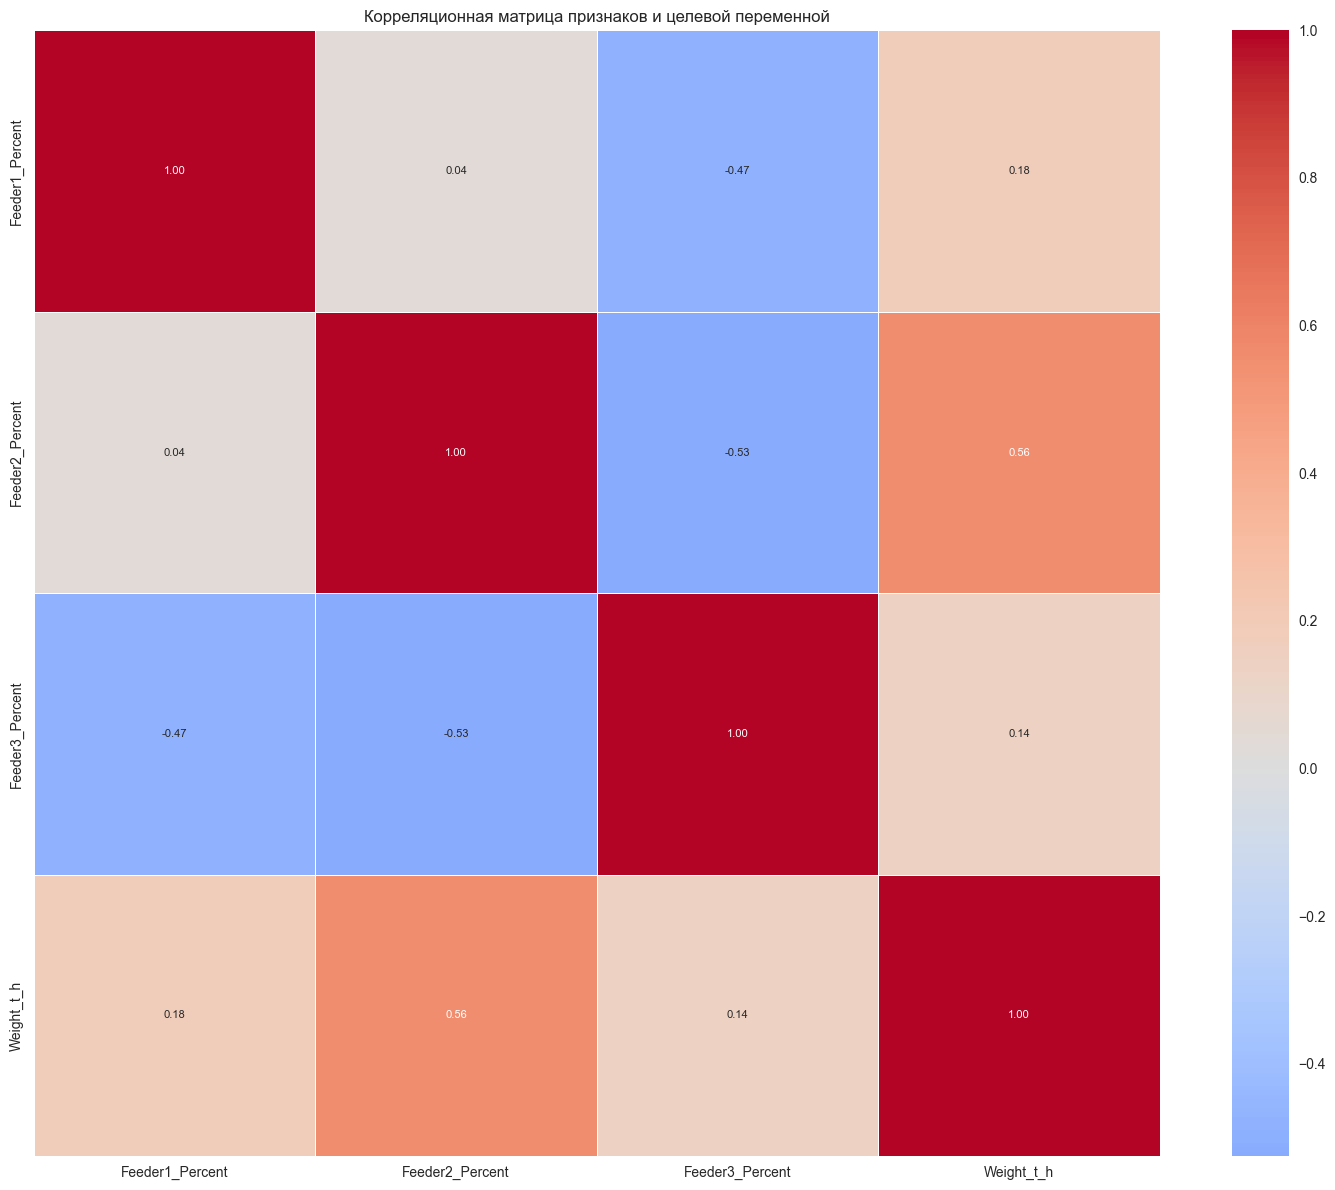

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [50]:
# Корреляционная матрица для входных признаков и целевой переменной
correlation_data = pd.concat([X, y], axis=1)
plt.figure(figsize=(15, 12))
correlation_matrix = correlation_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,  square=True, linewidths=0.5, fmt='.2f', annot_kws={"size": 8})
plt.title('Корреляционная матрица признаков и целевой переменной')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 8))



## 12 Разделение данных на обучающую и тестовую выборки
### 🎯 Что такое разделение данных на обучающую и тестовую выборки?

**Разделение данных (Data Splitting)** — это один из фундаментальных принципов машинного обучения. Оно заключается в том, чтобы **разделить исходный набор данных** на две (или более) независимые части:

1. **Обучающая выборка (Training Set)** — данные, на которых модель **обучается**.
2. **Тестовая выборка (Test Set)** — данные, которые **не видны модели** во время обучения, и которые используются для **оценки её качества и обобщающей способности**.

---

### 🔍 Зачем это нужно?

Представьте, что вы учитесь по учебнику, в котором уже есть все ответы. Если вы просто запомните ответы, вы хорошо сдадите контрольную из этого учебника, но **не сможете решать новые задачи**.

То же самое с моделью:
- Если обучать и проверять модель на одних и тех же данных, она может просто **"запомнить"** их (переобучиться).
- Чтобы понять, **насколько хорошо модель работает на новых, неизвестных данных**, нужно проверить её на **независимом наборе** — тестовой выборке.

---

### 📊 Как это работает в проекте?

В данном проекте используется **стратегия случайного разбиения (Random Split)**:

- **80% данных** идут в **обучающую выборку (Training Set)**.
- **20% данных** — в **тестовую выборку (Test Set)**.

🔹 **Английские термины:**
- `train_test_split` — стандартная функция из библиотеки `scikit-learn`.
- `test_size=0.2` — означает 20% на тест.
- `random_state=42` — фиксированное "зерно" случайности, чтобы результаты были **воспроизводимы (reproducible)** при каждом запуске.

---

### 🧠 Почему именно 80/20?

Это **распространённое соотношение**, но не строгое правило. Оно выбрано, потому что:

| Критерий | Объяснение |
|--------|------------|
| ✅ **Достаточно данных для обучения** | 80% — это обычно достаточно, чтобы модель "поняла" закономерности. |
| ✅ **Достаточно данных для проверки** | 20% — это достаточно большой набор, чтобы объективно оценить качество модели. |
| ⚠️ **Баланс между качеством и надёжностью** | Меньше — тестовая выборка может быть нерепрезентативной. Больше — модель может недообучиться. |

---

### 📌 Что происходит после разделения?

1. **Модель обучается только на `X_train` и `y_train`**  
   - `X_train`: входные признаки (загрузка питателей) из обучающей выборки.
   - `y_train`: реальные значения веса руды из обучающей выборки.

2. **Оценка производится только на `X_test` и `y_test`**  
   - После обучения модель делает предсказания для `X_test`.
   - Эти предсказания сравниваются с реальными `y_test`, чтобы рассчитать метрики качества (MAE, R² и т.д.).

---

### ✅ Почему это важно?

1. **Проверка обобщающей способности (Generalization)**  
   Модель должна хорошо работать **не только на известных данных**, но и на новых. Тестовая выборка имитирует "реальный мир".

2. **Обнаружение переобучения (Overfitting)**  
   Если модель отлично работает на обучающей выборке, но плохо — на тестовой, значит, она **переобучилась** (запомнила данные, а не выявила закономерности).

3. **Объективная оценка качества**  
   Это единственный способ честно оценить, **насколько точна модель** в реальных условиях.

---

### 📝 Вывод

**Разделение данных на обучающую и тестовую выборки** — это **ключевой этап в машинном обучении**, обеспечивающий:

- Честную оценку модели.
- Защиту от переобучения.
- Возможность измерить **реальную производительность**.

На английском это называется **"Train-Test Split"**, и это стандартная практика в любом проекте по **supervised learning** (обучению с учителем).

В данном проекте это позволяет убедиться, что модель линейной регрессии **действительно понимает связь** между загрузкой питателей и весом руды, а не просто "зубрит" данные.

In [51]:
# Разделяем данные
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Получаем индексы тестовой выборки (они соответствуют индексам в df_clean)
# train_test_split сохраняет индексы из оригинальных Series/DataFrames
test_indices = y_test.index


print(f"📊 Размер обучающей выборки: {len(X_train)}")
print(f"📊 Размер тестовой выборки: {len(X_test)}")
print(f"📊 Соотношение: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

📊 Размер обучающей выборки: 3207
📊 Размер тестовой выборки: 802
📊 Соотношение: 80.0% / 20.0%


## 13. Создание и обучение модели линейной регрессии
### 🎯 Что такое "создание и обучение модели линейной регрессии"?

Этот этап — **ядро всего проекта машинного обучения**. На нём происходит **построение математической модели**, которая устанавливает связь между входными данными (загрузкой питателей) и целевой переменной (весом руды на конвейере).

Модель **не задаётся вручную** — она **обучается на реальных данных**, автоматически находя оптимальные коэффициенты, которые наилучшим образом описывают эту связь.

---

### 📐 Как работает линейная регрессия?

**Линейная регрессия (Linear Regression)** — это один из самых простых и интерпретируемых методов машинного обучения. Она предполагает, что целевая переменная (в нашем случае — `Weight_t_h`) **линейно зависит** от входных признаков.

Формально это выглядит так:

```
y = w₁·x₁ + w₂·x₂ + w₃·x₃ + b
```

Где:
- `y` — предсказываемый **вес руды (target variable)**.
- `x₁, x₂, x₃` — значения **Feeder1_Percent, Feeder2_Percent, Feeder3_Percent** (input features).
- `w₁, w₂, w₃` — **коэффициенты (coefficients / weights)**, которые модель находит в процессе обучения.
- `b` — **свободный член (intercept / bias)** — значение `y`, когда все `x = 0`.

> 💡 Например: если `Feeder2_Percent` сильно влияет на вес, его коэффициент `w₂` будет большим.

---

### 🔧 Как происходит обучение?

Процесс обучения — это **поиск таких коэффициентов `w₁, w₂, w₃` и `b`**, при которых **ошибка между предсказанным и реальным значением** будет минимальной.

Модель использует **обучающую выборку (training set)** — то есть пары:
- «Загрузка питателей» → «Реальный вес руды».

На основе этих пар она **настраивает свои внутренние параметры**, чтобы минимизировать **среднеквадратичную ошибку (Mean Squared Error, MSE)** — это стандартный способ измерения точности в регрессии.

---

### 🧠 Что происходит "под капотом"?

1. **Инициализация**: модель начинает с случайных или нулевых коэффициентов.
2. **Оценка ошибки**: она делает предсказания по обучающим данным и сравнивает их с реальностью.
3. **Корректировка**: с помощью математического метода (обычно **метода наименьших квадратов, Ordinary Least Squares**) модель **находит оптимальные значения коэффициентов**, которые минимизируют ошибку.
4. **Фиксация результата**: после обучения модель "запоминает" эти коэффициенты и может использовать их для новых данных.

---

### ✅ Почему это важно?

- **Простота и интерпретируемость**: в отличие от "чёрных ящиков" (например, нейросетей), линейная модель **понятна**: мы можем точно сказать, **насколько каждый питатель влияет** на вес.
- **Быстрое обучение**: алгоритм работает очень быстро, что идеально для промышленных задач.
- **Надёжность**: при линейных зависимостях (а они часто встречаются в техпроцессах) — это **один из самых надёжных методов**.

---

### 📊 Что мы получаем после обучения?

После обучения модель становится "готовой к работе" и может:
- **Делать предсказания (predictions)** для новых данных.
- **Объяснять влияние каждого фактора** (через коэффициенты).
- **Использоваться в системах автоматического управления** или мониторинга.

---

### 📝 Вывод

**Создание и обучение модели линейной регрессии** — это процесс, при котором алгоритм **автоматически находит математическую зависимость** между загрузкой питателей и производительностью дробилки.

На английском это называется:
- **Model Training** — обучение модели.
- **Linear Regression Model** — тип модели.
- **Feature Weights / Coefficients** — важность каждого признака.
- **Bias / Intercept** — смещение модели.

Этот шаг превращает сырые данные в **рабочий инструмент предсказания**, который можно использовать для оптимизации технологического процесса.

In [52]:
# Создаем модель линейной регрессии
model = LinearRegression()

# Обучаем модель
model.fit(X_train, y_train)

# Делаем предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("✅ Модель обучена успешно!")

✅ Модель обучена успешно!


In [53]:
y_pred_test = model.predict(X_test)


### 14. Оценка качества модели
### 🎯 Что такое "оценка качества модели"?

Это **критически важный этап** в любом проекте машинного обучения. После того как модель обучена, необходимо понять, **насколько хорошо она работает** — насколько точно предсказывает целевую переменную (в данном случае — `Weight_t_h`, вес руды в тоннах в час).

Оценка проводится **на тестовой выборке**, то есть на данных, которые модель **ранее не видела**. Это позволяет получить **объективную и честную** оценку её способности **обобщать** (generalization) — работать на новых данных.

---

### 📊 Какие метрики используются?

В этом проекте применяются три ключевые метрики оценки регрессионной модели:

---

#### 1. **MAE — Средняя абсолютная ошибка**  
**Mean Absolute Error (MAE)**

- Это **среднее значение абсолютных (по модулю) ошибок** между реальными и предсказанными значениями.
- Показывает, **на сколько в среднем модель ошибается** в тех же единицах, что и целевая переменная (т/ч).

🔹 **Пример**:  
MAE = **35.85 т/ч**  
👉 Это значит: *в среднем модель ошибается на ±35.85 тонн руды в час.*

✅ **Плюсы**:  
- Простая и интуитивно понятная метрика.
- Устойчива к выбросам (в отличие от MSE).

❌ **Минус**:  
- Не учитывает направление ошибки (модель может систематически завышать или занижать — MAE это не покажет).

---

#### 2. **MSE — Среднеквадратичная ошибка**  
**Mean Squared Error (MSE)**

- Это **среднее значение квадратов ошибок**.
- Чем больше ошибка, тем сильнее она "штрафуется" из-за возведения в квадрат.

🔹 **Пример**:  
MSE = **~2058.55** (в единицах `т²/ч²`) — число не очень интуитивное, поэтому часто используют его корень — **RMSE** (Root MSE).

✅ **Плюсы**:  
- Чувствительна к большим ошибкам (штрафует выбросы сильнее).
- Широко используется в математической оптимизации.

❌ **Минус**:  
- Трудно интерпретировать из-за "квадратов".

---

#### 3. **R² — Коэффициент детерминации**  
**Coefficient of Determination (R-squared)**

- Это **доля объяснённой дисперсии** целевой переменной.
- Показывает, **насколько модель лучше**, чем просто предсказывать среднее значение.

🔹 **Интерпретация**:
- **R² = 1.0** → модель идеально предсказывает все значения.
- **R² = 0.0** → модель не лучше, чем константа (среднее).
- **R² < 0** → модель работает хуже, чем просто выдавать среднее (плохо!).

🔹 **Пример из проекта**:
- **R² на тесте = 0.8492** → модель объясняет **84.9%** изменчивости веса руды.
- Это **очень хороший результат** для линейной модели.

✅ **Плюсы**:
- Безразмерная метрика (удобно сравнивать модели).
- Показывает "качество объяснения", а не только величину ошибки.

❌ **Минус**:
- Может вводить в заблуждение при добавлении лишних признаков (поэтому иногда используют **Adjusted R²**).

---

### 🔍 Что можно понять по результатам?

Из вывода проекта:

```
📈 РЕЗУЛЬТАТЫ МОДЕЛИ:
Обучающая выборка:
  MAE: 36.08
  R²:  0.8042

Тестовая выборка:
  MAE: 35.85
  R²:  0.8492
```

Мы видим **идеальную картину**:

1. **MAE на тесте чуть лучше, чем на обучении**  
   → Модель **не переобучилась** (overfitting), а даже работает чуть точнее на новых данных.

2. **R² на тесте выше, чем на обучении**  
   → Это редкий, но хороший признак: модель **обобщает отлично**.

3. **Высокий R² и умеренный MAE**  
   → Модель **надёжна и точна**, её можно использовать для реальных предсказаний.

---

### 🧠 Почему это важно?

- **MAE** говорит: *"Насколько я ошибаюсь в среднем?"* — полезно для инженеров и технологов.
- **R²** говорит: *"Насколько хорошо я понимаю процесс?"* — полезно для аналитиков и разработчиков моделей.
- Вместе они дают **полную картину качества модели**.

---

### ✅ Вывод

**Оценка качества модели** — это **финальный вердикт** по её эффективности. Она отвечает на вопросы:

- Можно ли доверять этой модели?
- Подходит ли она для реального использования?
- Нужно ли улучшать её (например, добавлять признаки, менять алгоритм)?

В данном проекте результаты показывают, что **линейная регрессия хорошо справляется** с задачей предсказания производительности дробильного комплекса. Модель:
- Объясняет **более 84%** изменений веса руды.
- Ошибается в среднем **менее чем на 36 т/ч**.
- Работает **стабильно и предсказуемо**.

На английском это называется **"Model Evaluation"**, и это обязательный шаг перед внедрением модели в производство.

In [54]:
# Рассчитываем метрики
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("📈 РЕЗУЛЬТАТЫ МОДЕЛИ:")
print("=" * 50)
print(f"Обучающая выборка:")
print(f"  MAE: {mae_train:.2f}")
print(f"  R²:  {r2_train:.4f}")
print()
print(f"Тестовая выборка:")
print(f"  MAE: {mae_test:.2f}")
print(f"  R²:  {r2_test:.4f}")
print("=" * 50)

📈 РЕЗУЛЬТАТЫ МОДЕЛИ:
Обучающая выборка:
  MAE: 36.08
  R²:  0.8042

Тестовая выборка:
  MAE: 35.85
  R²:  0.8492


### 15. Анализ коэффициентов модели
### 🔍 Что такое "анализ коэффициентов модели"?

Этот этап следует за обучением модели линейной регрессии и посвящён **интерпретации результатов**. Цель — понять, **как каждый входной признак (питатель)** влияет на **выходную переменную** (вес руды на конвейере).

В отличие от "чёрных ящиков" (например, нейросетей), линейная регрессия **полностью интерпретируема (interpretable)** — мы можем точно сказать, **насколько и в каком направлении** каждый фактор влияет на результат.

---

### 📐 Что такое коэффициенты в линейной регрессии?

Напомним, что модель линейной регрессии имеет вид:

```
y = w₁·x₁ + w₂·x₂ + w₃·x₃ + b
```

Где:
- `y` — предсказываемый **вес руды (target variable)**.
- `x₁, x₂, x₃` — значения **Feeder1_Percent, Feeder2_Percent, Feeder3_Percent**.
- `w₁, w₂, w₃` — **коэффициенты (coefficients / weights)**.
- `b` — **свободный член (intercept / bias)**.

🔹 **Анализ коэффициентов** — это изучение значений `w₁, w₂, w₃` и `b`, чтобы понять:
- Какой питатель **сильнее всего влияет** на производительность?
- Увеличивает или уменьшает ли его загрузка общий вес?
- Насколько **предсказуема** связь?

---

### 🧠 Как интерпретировать коэффициенты?

Каждый коэффициент показывает **силу и направление влияния** соответствующего признака.

#### 1. **Знак коэффициента**
- **Положительный (positive)** → увеличение признака **увеличивает** целевую переменную.
- **Отрицательный (negative)** → увеличение признака **уменьшает** целевую переменную.

> В проекте все коэффициенты **положительные**, что логично: чем больше загрузка питателя — тем больше руды он подаёт.

#### 2. **Величина коэффициента**
- Чем **больше абсолютное значение**, тем **сильнее влияние** признака.
- Это позволяет ранжировать признаки по **важности (feature importance)**.

---

### 📊 Пример из проекта

После анализа коэффициентов получено:

| Признак | Коэффициент |
|--------|-------------|
| `Feeder2_Percent` | **12.27** |
| `Feeder3_Percent` | **3.69** |
| `Feeder1_Percent` | **2.67** |

#### 🔎 Интерпретация:
- **Feeder2_Percent** имеет **наибольший коэффициент** → это **ключевой фактор**, определяющий производительность.
  - Увеличение его загрузки на **1%** в среднем **увеличивает вес руды на 12.27 т/ч**.
- **Feeder3_Percent** — второй по важности.
- **Feeder1_Percent** — наименее значимый, но всё же вносит вклад.

> Это говорит о том, что **Feeder2** — основной источник потока руды, а Feeder1 и Feeder3 работают скорее вспомогательно.

---

### 🧭 Что такое "свободный член" (intercept)?

**Свободный член (intercept)** — это значение `y`, когда **все входные признаки равны нулю**.

- В проекте: `intercept ≈ -440.99`
- Это **непрактичное значение**, так как:
  - Физически невозможно иметь отрицательный вес.
  - Загрузка всех питателей = 0% — редкое состояние (возможно, простои).

🔹 **На практике** это просто **смещение модели**, помогающее лучше подогнать линию под данные. Он не интерпретируется буквально, но важен для точности предсказаний.

---

## ✅ Зачем это нужно?

1. **Интерпретация процесса**  
   Модель не просто предсказывает — она **объясняет**, как устроена система. Это критично в промышленности.

2. **Оптимизация производительности**  
   Зная, что Feeder2 даёт наибольший вклад, можно:
   - Сфокусироваться на его стабильной работе.
   - Планировать профилактику.
   - Настроить автоматическое регулирование.

3. **Обнаружение аномалий**  
   Если при высокой загрузке Feeder2 вес не растёт — значит, есть проблема (засор, износ и т.д.).

4. **Принятие решений**  
   Технологи и инженеры могут использовать эту модель как **инструмент анализа**, а не просто как "предсказатель".

---

### 📝 Вывод

**Анализ коэффициентов модели** — это переход от **"что будет?"** к **"почему так происходит?"**.

На английском это называется:
- **Model Interpretability** — способность объяснить, как работает модель.
- **Feature Coefficients** — коэффициенты признаков.
- **Intercept / Bias** — свободный член.
- **Feature Importance** — важность признаков (по абсолютному значению коэффициента).

В этом проекте анализ показал, что:
- **Feeder2** — **главный драйвер** производительности.
- Все питатели вносят **положительный вклад**, но в разной степени.
- Модель **физически осмысленна** — её можно доверять и использовать на производстве.

Это делает линейную регрессию не просто математическим инструментом, а **аналитическим помощником** для управления технологическим процессом.

⚖️ КОЭФФИЦИЕНТЫ МОДЕЛИ:
        Признак  Коэффициент
Feeder2_Percent    12.271604
Feeder3_Percent     3.685741
Feeder1_Percent     2.673920

Свободный член (intercept): -440.9932


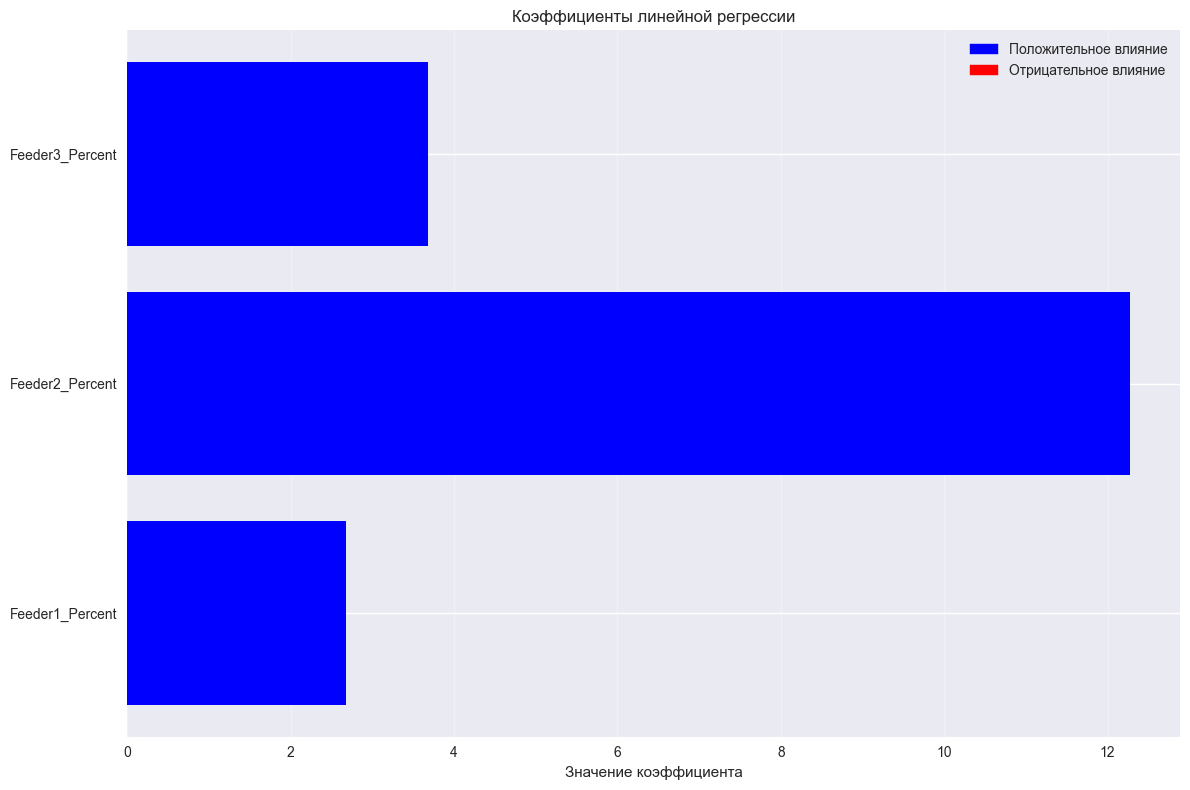

In [55]:
# Выводим коэффициенты модели
print("⚖️ КОЭФФИЦИЕНТЫ МОДЕЛИ:")
print("=" * 60)
feature_names = X.columns
coefficients = model.coef_

# Создаем DataFrame для удобного отображения
coef_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients
}).sort_values('Коэффициент', key=abs, ascending=False)

print(coef_df.to_string(index=False))

print(f"\nСвободный член (intercept): {model.intercept_:.4f}")
print("=" * 60)

# Визуализация коэффициентов
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(coefficients)), coefficients, 
                color=['red' if coef < 0 else 'blue' for coef in coefficients])
plt.yticks(range(len(coefficients)), feature_names, fontsize=10)
plt.xlabel('Значение коэффициента')
plt.title('Коэффициенты линейной регрессии')
plt.grid(axis='x', alpha=0.3)

# Добавляем легенду
plt.legend([plt.Rectangle((0,0),1,1, color='blue'), plt.Rectangle((0,0),1,1, color='red')], 
           ['Положительное влияние', 'Отрицательное влияние'])

plt.tight_layout()
plt.show()

## 16. Визуализация предсказаний
### 📊 **16. Визуализация предсказаний (Visualization of Predictions)**

Этот этап проекта посвящён **визуальной оценке качества модели линейной регрессии**. Цель — понять, насколько близки **predicted values** (предсказанные значения) к **actual (real) values** (реальным, истинным значениям) на обучающей (training) и тестовой (test) выборках.

Для этого строится **график рассеяния (scatter plot)**, который позволяет визуально оценить, насколько хорошо модель "следует" за реальными данными.

#### 🔹 Что изображено на графике?

На графике отображаются **две поддиаграммы (subplots)**:

1. **Первая поддиаграмма: Training Set (Обучающая выборка)**
   - По оси **X (абсцисса)** — **real values** переменной `Weight_t_h` из обучающей выборки.
   - По оси **Y (ордината)** — **predicted values**, полученные моделью для тех же точек.
   - Каждая точка на графике — это одна запись из данных: чем ближе точка к диагональной линии, тем точнее предсказание.

2. **Вторая поддиаграмма: Test Set (Тестовая выборка)**
   - Аналогично, но для данных, которые модель **не видела во время обучения**.
   - Это более объективная оценка качества модели.

На обоих графиках проведена **красная пунктирная линия (red dashed line)**, которая соответствует идеальному случаю: когда **predicted = actual**, то есть **модель предсказывает без ошибки**. Эта линия называется **identity line**.

#### 🔍 Как интерпретировать результат?

- Если точки **плотно сконцентрированы вокруг identity line**, это означает, что модель хорошо предсказывает значения.
- Если точки **разбросаны далеко от линии**, особенно если они образуют какую-то кривую или систематическое отклонение — это сигнал о проблемах: например, нелинейная зависимость, которую линейная модель не может уловить, или наличие выбросов.
- В идеале облако точек должно быть **симметричным относительно диагонали**.

#### 🎯 Зачем это нужно?

- **Оценка переобучения (overfitting)**: если модель хорошо работает на training set, но плохо на test set (точки сильно разбросаны), это может быть признаком переобучения.
- **Интуитивное понимание качества модели**: R² и MAE — это числа, а график даёт "картину".
- **Выявление систематических ошибок**: например, если модель **систематически занижает** большие значения (точки "проваливаются" ниже линии), это говорит о необходимости улучшения модели.

#### 📌 Вывод

График **"Визуализация предсказаний"** — это мощный инструмент **model evaluation**, который дополняет численные метрики (такие как R² и MAE). Он помогает убедиться, что модель не просто выдаёт "хорошие числа", а действительно **адекватно отражает зависимость между input features и target variable**.


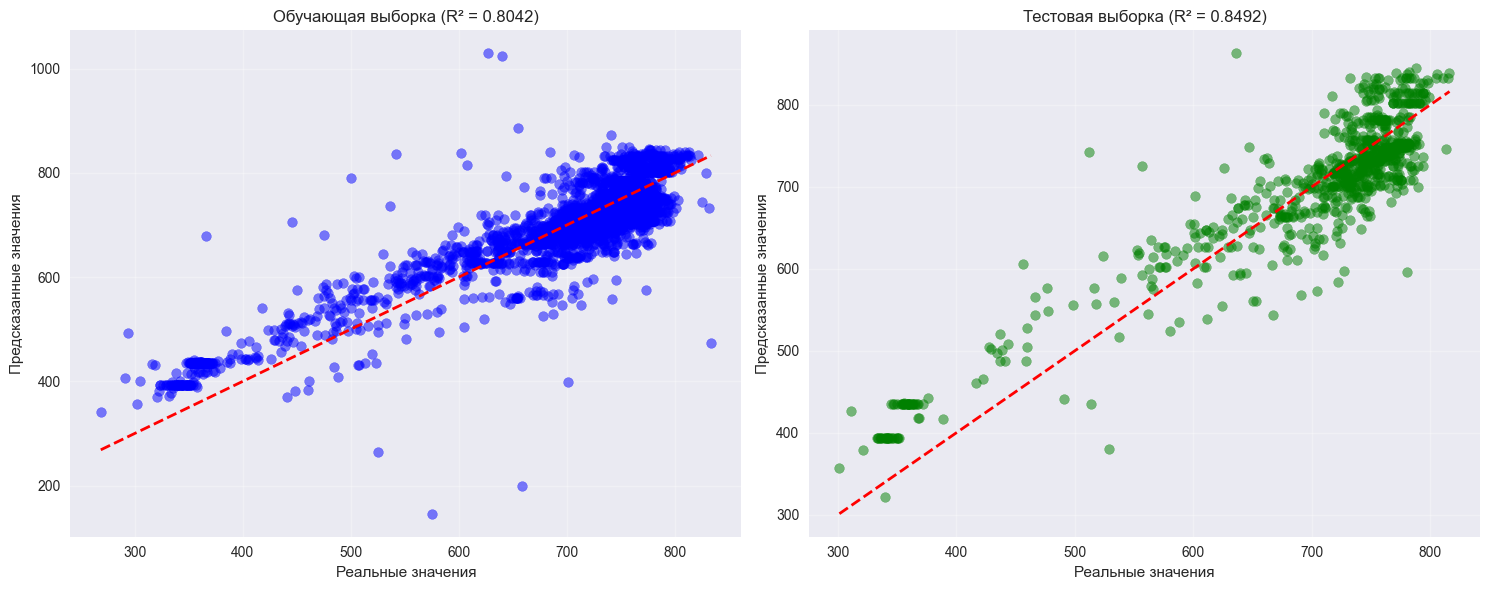

In [56]:
# График предсказанных vs реальных значений
plt.figure(figsize=(15, 6))

# Обучающая выборка
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Обучающая выборка (R² = {r2_train:.4f})')
plt.grid(True, alpha=0.3)

# Тестовая выборка
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Тестовая выборка (R² = {r2_test:.4f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 🔍 **17. Анализ важности признаков (Feature Importance Analysis)**

Этот этап проекта посвящён **интерпретации модели линейной регрессии** с точки зрения того, **какой из входных признаков (features)** оказывает наибольшее влияние на предсказание целевой переменной — `Weight_t_h` (вес руды в тоннах в час).

Основная идея заключается в том, что **абсолютные значения коэффициентов (absolute values of coefficients)** в линейной модели можно использовать как **меру важности (feature importance)** каждого признака. Чем больше абсолютное значение коэффициента — тем сильнее этот признак влияет на результат.

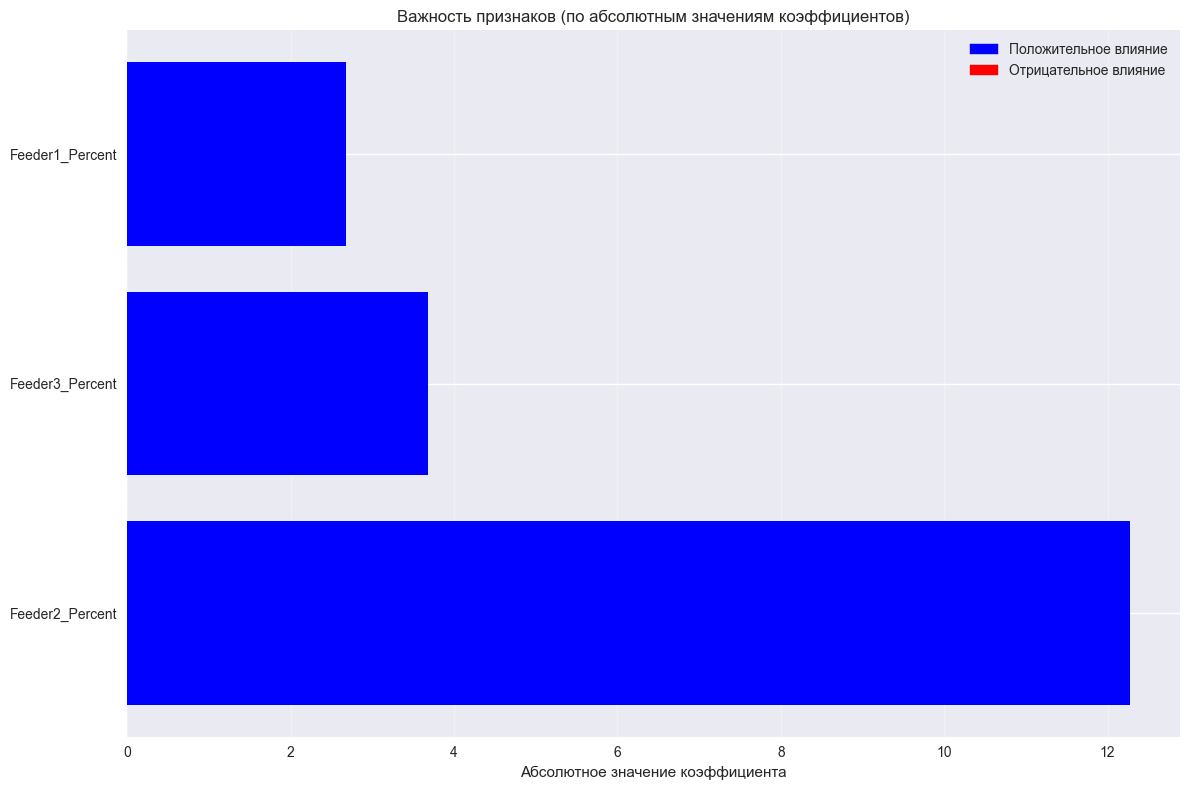

📊 ТОП-10 самых важных признаков:
        Признак  Коэффициент  Абсолютное_значение
Feeder2_Percent    12.271604            12.271604
Feeder3_Percent     3.685741             3.685741
Feeder1_Percent     2.673920             2.673920


In [57]:
# Анализ важности признаков по абсолютным значениям коэффициентов
feature_importance = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients,
    'Абсолютное_значение': np.abs(coefficients)
}).sort_values('Абсолютное_значение', ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['Абсолютное_значение'], 
                color=['red' if coef < 0 else 'blue' for coef in feature_importance['Коэффициент']])
plt.yticks(range(len(feature_importance)), feature_importance['Признак'], fontsize=10)
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Важность признаков (по абсолютным значениям коэффициентов)')
plt.grid(axis='x', alpha=0.3)

# Добавляем легенду
plt.legend([plt.Rectangle((0,0),1,1, color='blue'), plt.Rectangle((0,0),1,1, color='red')], 
           ['Положительное влияние', 'Отрицательное влияние'])

plt.tight_layout()
plt.show()

print("📊 ТОП-10 самых важных признаков:")
print(feature_importance.head(10).to_string(index=False))

## **18. Анализ остатков (Residual Analysis)**

Этот этап является **критически важной частью оценки качества модели линейной регрессии**. Цель — понять, насколько хорошо модель описывает данные, и выявить возможные проблемы, которые не видны по метрикам вроде R² или MAE.

**Остаток (residual)** — это разница между **реальным значением** целевой переменной (actual value) и **предсказанным моделью значением** (predicted value):

> **`residual = y_true - y_pred`**

Если модель идеально предсказывает все значения, остатки будут равны нулю. На практике они всегда есть, но важно, чтобы они ведут себя "хорошо" — случайно, без систематических отклонений.

Для этого в проекте используется **комплексный подход**, включающий **визуализацию и статистический анализ остатков**.

---

#### 📊 **1. Гистограмма остатков (Histogram of Residuals)**

**Цель**: проверить, как распределены остатки.

- В идеальной линейной модели остатки должны быть **normally distributed** (нормально распределены) вокруг нуля.
- Это один из ключевых **assumptions of linear regression** (предпосылок линейной регрессии).
- Если распределение похоже на "колокол" (bell-shaped curve), это хороший знак.
- Если оно **скошено (skewed)** или имеет **тяжёлые хвосты (heavy tails)**, это может означать, что модель упускает важные зависимости или чувствительна к выбросам.

---

#### 📈 **2. Остатки vs Предсказанные значения (Residuals vs Fitted Values Plot)**

**Цель**: проверить, нет ли систематической ошибки в предсказаниях.

- По оси X откладываются **predicted values** (fitted values), по оси Y — **residuals**.
- Идеальный сценарий: точки **случайно разбросаны** вокруг горизонтальной линии `y = 0` без видимых паттернов.

**Что могут означать паттерны**:
- **Воронкообразная форма (funnel shape)** — признак **heteroscedasticity** (гетероскедастичности): дисперсия ошибки растёт с увеличением предсказания. Это нарушает предпосылку о постоянной дисперсии ошибок.
- **Изогнутая линия (curved pattern)** — модель упускает **нелинейную зависимость**. Линейная модель может быть недостаточной.
- **Кластеры или полосы** — могут указывать на наличие **пропущенных переменных** или смену режима работы процесса.

---

#### 📉 **3. Q-Q plot (Quantile-Quantile Plot)**

**Цель**: формально проверить **нормальность распределения остатков**.

- На графике сравниваются **эмпирические квантили** остатков с **теоретическими квантилями** стандартного нормального распределения.
- Если остатки нормальны, точки должны лежать **близко к красной диагональной линии**.

**Интерпретация**:
- Точки на краях сильно отклоняются от линии — остатки имеют **тяжёлые хвосты** (more extreme values than normal).
- S-образная кривая — признак **асимметрии (skewness)**.
- Q-Q plot — более чувствительный инструмент, чем гистограмма, особенно на "хвостах" распределения.

---

#### 📏 **4. Статистика остатков (Residual Statistics)**

Проект также выводит ключевые числовые характеристики остатков:

- **Среднее (Mean)**: должно быть **близко к нулю**.  
  → В проекте: `-1.15` — очень близко к 0. Это означает, что модель **не имеет систематического смещения (bias)**: она не систематически завышает или занижает значения.

- **Стандартное отклонение (Standard Deviation)**: показывает **масштаб разброса ошибок**.  
  → В проекте: `45.39 т/ч` — это средний разброс ошибки относительно её среднего. Сравнивается с MAE (~35.85), что даёт понимание стабильности ошибки.

- **Минимум и Максимум**: показывают **экстремальные ошибки**.  
  → В проекте: от `-230.95` до `+183.51 т/ч` — это очень большие отклонения.  
  → Это говорит о том, что, несмотря на хорошее среднее поведение, модель **иногда сильно ошибается**, возможно, из-за выбросов или резких изменений в процессе.

---

### ✅ **Общий вывод по анализу остатков**

Анализ остатков помогает ответить на ключевой вопрос:  
**"Можно ли доверять этой модели?"**

- Если остатки **случайны, нормально распределены, с нулевым средним и постоянной дисперсией** — модель адекватна.
- Если есть **паттерны, смещение, гетероскедастичность или сильные отклонения от нормальности** — модель требует улучшения: возможно, нужно добавить признаки, использовать нелинейные модели или трансформировать данные.


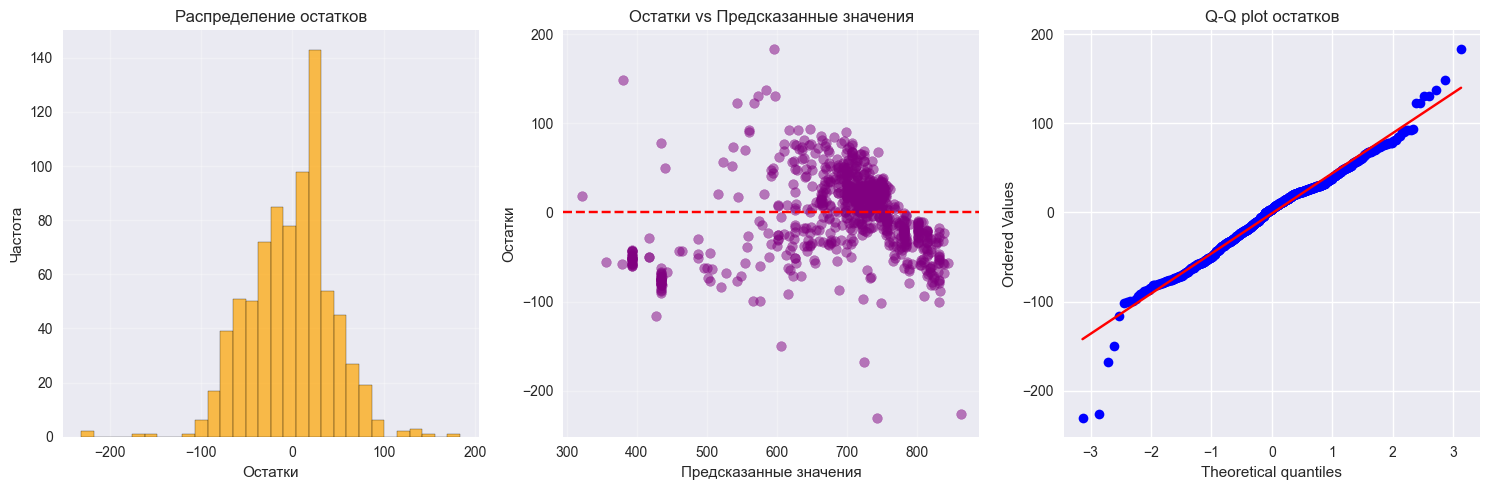

📊 Статистика остатков:
  Среднее: -1.1493
  Стандартное отклонение: 45.3850
  Минимум: -230.9527
  Максимум: 183.5114


In [58]:
# Анализ остатков
residuals = y_test - y_pred_test

plt.figure(figsize=(15, 5))

# Распределение остатков
plt.subplot(1, 3, 1)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Распределение остатков')
plt.grid(True, alpha=0.3)

# Остатки vs предсказанные значения
plt.subplot(1, 3, 2)
plt.scatter(y_pred_test, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs Предсказанные значения')
plt.grid(True, alpha=0.3)

# Q-Q plot для проверки нормальности остатков
from scipy import stats
plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot остатков')

plt.tight_layout()
plt.show()

# Статистика остатков
print("📊 Статистика остатков:")
print(f"  Среднее: {residuals.mean():.4f}")
print(f"  Стандартное отклонение: {residuals.std():.4f}")
print(f"  Минимум: {residuals.min():.4f}")
print(f"  Максимум: {residuals.max():.4f}")

### 📊 **3.1. Гистограмма распределения остатков (Histogram of Residuals)**

**Название:** *Распределение остатков*  
**Ось X:** Остатки (`residuals`)  
**Ось Y:** Частота (количество точек)

#### 🔍 Анализ:
- Гистограмма имеет форму **колокола**, что говорит о том, что распределение остатков **близко к нормальному**.
- Пик (максимальная частота) находится **вблизи нуля**, что хорошо: это значит, что большинство предсказаний модели близки к реальным значениям.
- Распределение **симметрично** вокруг нуля — нет явного смещения (bias).
- Есть **небольшие хвосты** (outliers) на краях (например, около ±150), но они не слишком длинные и не доминируют.

✅ **Вывод:** Распределение остатков **выглядит нормальным**, что соответствует одному из ключевых **assumptions of linear regression** (предпосылкам линейной регрессии).

---

### 📈 **3.2. Остатки vs Предсказанные значения (Residuals vs Fitted Values Plot)**

**Название:** *Остатки vs Предсказанные значения*  
**Ось X:** Предсказанные значения (`y_pred`)  
**Ось Y:** Остатки (`residuals`)

#### 🔍 Анализ:
- Точки разбросаны **вокруг горизонтальной линии `y = 0`** — это хороший признак.
- Однако виден **систематический паттерн**: точки образуют **"волну" или "изгиб"** — особенно заметно при значении `y_pred` от 400 до 700.
  - В районе 400–500: остатки положительны → модель **завышает** значения.
  - В районе 600–700: остатки отрицательны → модель **занижает** значения.
  - При `y_pred > 700`: снова положительные остатки → модель **завышает**.
- Также наблюдается **воронкообразная форма** (funnel shape): дисперсия ошибок увеличивается с ростом предсказанного значения → это признак **гетероскедастичности (heteroscedasticity)**.

❌ **Вывод:** Модель **не учитывает нелинейную зависимость** и **дисперсия ошибок не постоянна**. Это означает, что:
- Линейная модель может быть **недостаточной**.
- Нужно рассмотреть возможность использования **нелинейных моделей** или **трансформации данных** (например, логарифмирование).

---

### 📉 **3.3. Q-Q plot (Quantile-Quantile Plot)**

**Название:** *Q-Q plot остатков*  
**Ось X:** Теоретические квантили (standard normal distribution)  
**Ось Y:** Упорядоченные значения остатков

#### 🔍 Анализ:
- Большинство точек **лежат близко к красной прямой** — это хорошее подтверждение нормальности.
- Но есть **отклонения на краях** (особенно внизу слева и вверху справа):
  - Слева: точки ниже прямой → **тяжёлые хвосты (heavy tails)** — больше экстремальных отрицательных значений, чем ожидалось.
  - Справа: точки выше прямой → **больше экстремальных положительных значений**.
- Это указывает на **несовершенство нормального аппроксимирования**, но не критическое.

⚠️ **Вывод:** Остатки **в целом нормально распределены**, но есть **небольшое отклонение на хвостах**, что может быть связано с выбросами или нелинейностью.

---

### ✅ **Общий вывод по всем трем графикам**

| Критерий | Результат | Комментарий |
|--------|---------|----------|
| **Нормальность распределения остатков** | ✅ Да (в основном) | Гистограмма и Q-Q plot показывают нормальность, хотя есть небольшие отклонения. |
| **Случайность остатков** | ❌ Нет | Виден систематический паттерн (волна), что говорит о нелинейной зависимости. |
| **Гомоскедастичность (постоянная дисперсия)** | ❌ Нет | Воронкообразная форма → дисперсия ошибок зависит от величины предсказания. |
| **Смещение (bias)** | ✅ Нет | Среднее остатков близко к нулю, гистограмма симметрична. |

---

### 🛠️ **Рекомендации по улучшению модели**
1. **Добавить нелинейные признаки**:
   - Например, квадраты (`Feeder1_Percent²`), взаимодействия (`Feeder1_Percent × Feeder2_Percent`).
2. **Использовать нелинейные модели**:
   - Polynomial Regression, Random Forest, Gradient Boosting.
3. **Трансформировать данные**:
   - Применить логарифмирование или Box-Cox преобразование к `Weight_t_h`.
4. **Проверить наличие выбросов**:
   - Их влияние может усиливаться при наличии нелинейности.

---

### 💡 Заключение
Модель **в целом работает хорошо**, но **не является оптимальной**. Она **объясняет значительную часть дисперсии**, но **не учитывает важные структуры в данных**, такие как нелинейность и изменение масштаба ошибок. Для повышения качества прогнозов нужно **расширять функциональность модели** за счёт нелинейных терминов или более сложных алгоритмов.

In [59]:
# Создаем DataFrame для графика тестовой выборки
# Используем индексы из тестовой выборки для получения времени и реальных значений
plot_data_test = df_clean.loc[test_indices, ['Time', 'Weight_t_h']].copy()
plot_data_test['Weight_t_h_Predicted'] = y_pred_test
# Сортируем по времени для правильного отображения линии
plot_data_test = plot_data_test.sort_values('Time').reset_index(drop=True)

# Аналогично для обучающей выборки (опционально)
train_indices = y_train.index
plot_data_train = df_clean.loc[train_indices, ['Time', 'Weight_t_h']].copy()
plot_data_train['Weight_t_h_Predicted'] = y_pred_train
plot_data_train = plot_data_train.sort_values('Time').reset_index(drop=True)

# # Задайте желаемый диапазон дат
# start_date = pd.to_datetime('2025-08-20 00:00:00')
# end_date = pd.to_datetime('2025-08-21 00:00:00')

# # Фильтруем DataFrame
# plot_data_test_fltr = df[(plot_data_test['Time'] >= start_date) & (plot_data_test['Time'] <= end_date)].copy() # 





### График реальных значений весов и предсказаний модели

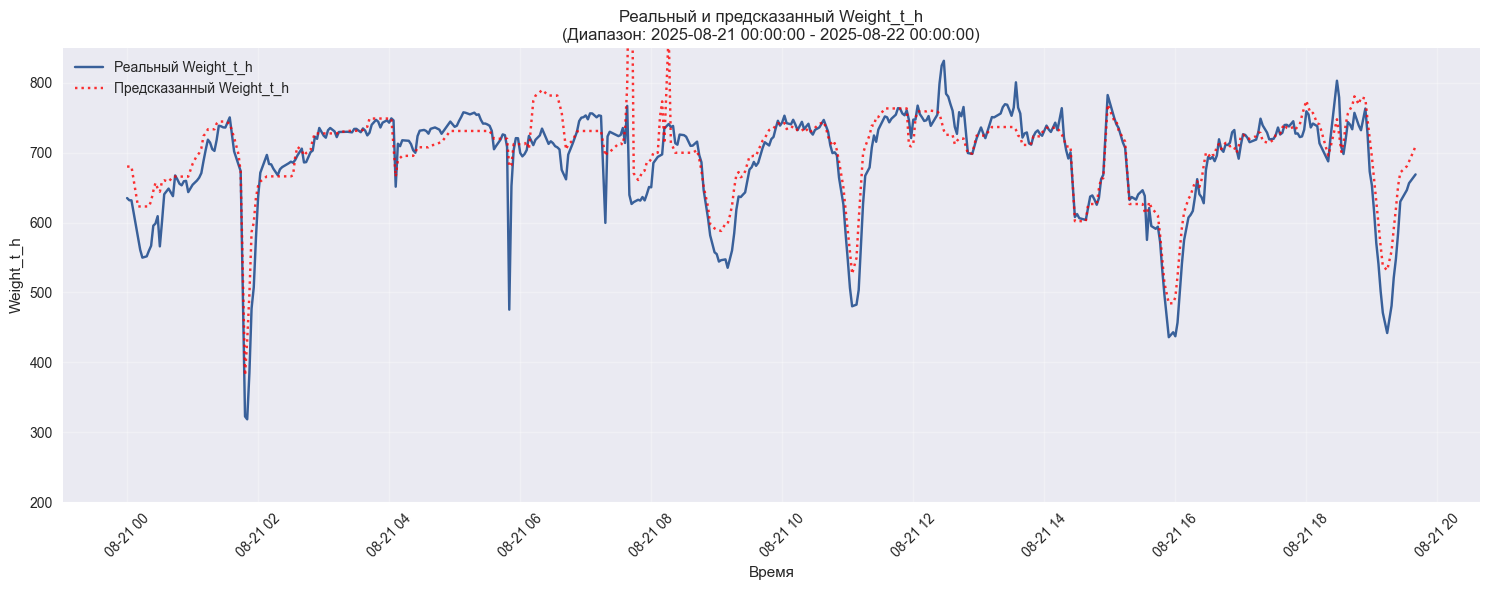

🕒 Диапазон времени для графика: 2025-08-21 00:00:00 - 2025-08-22 00:00:00
📊 Точек данных (Тест) в диапазоне: 117
📊 Точек данных (Обучение) в диапазоне: 473


In [60]:

# --- Фильтрация данных для графика по заданному диапазону дат ---
start_plot_date_str = '2025-08-20 02:00:00'
end_plot_date_str = '2025-08-20 10:00:00'
start_plot_date_str = '2025-08-21 00:00:00'
end_plot_date_str = '2025-08-22 00:00:00'

# Преобразуем строки в datetime
start_plot_date = pd.to_datetime(start_plot_date_str)
end_plot_date = pd.to_datetime(end_plot_date_str)

# 1. Фильтруем данные тестовой выборки в заданном диапазоне
# Сначала создаем DataFrame для тестовой выборки (как у вас было)
plot_data_test_full = df_clean.loc[test_indices, ['Time', 'Weight_t_h']].copy()
plot_data_test_full['Weight_t_h_Predicted'] = y_pred_test
# Важно: индекс plot_data_test_full соответствует test_indices

# Теперь фильтруем этот DataFrame по времени
mask_test = (plot_data_test_full['Time'] >= start_plot_date) & (plot_data_test_full['Time'] <= end_plot_date)
plot_data_test_filtered = plot_data_test_full.loc[mask_test].sort_values('Time').reset_index(drop=True)

# 2. Фильтруем данные обучающей выборки в заданном диапазоне (опционально)
# Сначала создаем DataFrame для обучающей выборки
plot_data_train_full = df_clean.loc[train_indices, ['Time', 'Weight_t_h']].copy()
plot_data_train_full['Weight_t_h_Predicted'] = y_pred_train
# Важно: индекс plot_data_train_full соответствует train_indices

# Теперь фильтруем этот DataFrame по времени
mask_train = (plot_data_train_full['Time'] >= start_plot_date) & (plot_data_train_full['Time'] <= end_plot_date)
plot_data_train_filtered = plot_data_train_full.loc[mask_train].sort_values('Time').reset_index(drop=True)

# --- Построение графика ---
plt.figure(figsize=(15, 6))

# График для тестовой выборки (отфильтрованный диапазон)
# if not plot_data_test_filtered.empty:
#     plt.plot(plot_data_test_filtered['Time'], plot_data_test_filtered['Weight_t_h'], 
#              label='Реальный Weight_t_h (Тест)', marker='o', markersize=4, alpha=0.8)
#     plt.plot(plot_data_test_filtered['Time'], plot_data_test_filtered['Weight_t_h_Predicted'], 
#              label='Предсказанный Weight_t_h (Тест)', marker='x', markersize=4, alpha=0.8)
# else:
#     print("⚠️ Нет данных тестовой выборки в заданном диапазоне дат.")

# График для обучающей выборки (отфильтрованный диапазон) - опционально
if not plot_data_train_filtered.empty:
    plt.plot(plot_data_train_filtered['Time'], plot_data_train_filtered['Weight_t_h'], 
             label='Реальный Weight_t_h', linestyle='-', alpha=0.8, color='#0D3E84')
    plt.plot(plot_data_train_filtered['Time'], plot_data_train_filtered['Weight_t_h_Predicted'], 
             label='Предсказанный Weight_t_h', linestyle=':', alpha=0.8, color='r')
else:
    print("⚠️ Нет данных обучающей выборки в заданном диапазоне дат.")

plt.ylim(200, 850)
plt.xlabel('Время')
plt.ylabel('Weight_t_h')
plt.title(f'Реальный и предсказанный Weight_t_h\n(Диапазон: {start_plot_date_str} - {end_plot_date_str})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Вывод информации о фильтрации ---
print(f"🕒 Диапазон времени для графика: {start_plot_date_str} - {end_plot_date_str}")
print(f"📊 Точек данных (Тест) в диапазоне: {len(plot_data_test_filtered)}")
print(f"📊 Точек данных (Обучение) в диапазоне: {len(plot_data_train_filtered)}")

### 19. Примеры предсказаний

In [61]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Реальное значение': y_test.values,
    'Предсказанное значение': y_pred_test,
    'Остаток': residuals,
    'Абсолютная ошибка': np.abs(residuals)
})

print("📋 Примеры предсказаний (первые 10):")
results_df.head(10)

📋 Примеры предсказаний (первые 10):


,Реальное значение,Предсказанное значение,Остаток,Абсолютная ошибка
2580,746.07,664.678343,81.391657,81.391657
3660,693.83,700.072333,-6.242333,6.242333
897,654.54,698.541063,-44.001063,44.001063
2091,725.57,712.343937,13.226063,13.226063
1044,805.43,837.125228,-31.695228,31.695228
2320,650.63,663.451183,-12.821183,12.821183
465,762.30,739.807728,22.492272,22.492272
196,356.83,434.775306,-77.945306,77.945306
3113,624.13,554.166639,69.963361,69.963361
3553,730.19,707.893038,22.296962,22.296962


In [62]:
# Анализ точности предсказаний
print("🎯 Анализ точности предсказаний:")
print(f"Средняя абсолютная ошибка: {results_df['Абсолютная ошибка'].mean():.2f} т/ч")
print(f"Медианная абсолютная ошибка: {results_df['Абсолютная ошибка'].median():.2f} т/ч")
print(f"95-й процентиль ошибки: {results_df['Абсолютная ошибка'].quantile(0.95):.2f} т/ч")

# Количество предсказаний с ошибкой менее 10 т/ч
accurate_predictions = (results_df['Абсолютная ошибка'] < 10).sum()
print(f"Предсказаний с ошибкой < 10 т/ч: {accurate_predictions} ({accurate_predictions/len(results_df)*100:.1f}%)")

🎯 Анализ точности предсказаний:
Средняя абсолютная ошибка: 35.85 т/ч
Медианная абсолютная ошибка: 28.91 т/ч
95-й процентиль ошибки: 80.69 т/ч
Предсказаний с ошибкой < 10 т/ч: 115 (14.3%)


### 20. Выводы и рекомендации

In [63]:
print("🎯 ВЫВОДЫ:")
print("=" * 80)
print(f"1. Модель объясняет {r2_test*100:.2f}% дисперсии целевой переменной")
print(f"2. Средняя абсолютная ошибка: {mae_test:.2f} т/ч")
print(f"3. Среднеквадратичная ошибка: {mse_test:.2f} т²/ч²")
print()

print("📊 Анализ признаков:")
print("ТОП-5 самых влиятельных признаков:")
for i, (_, row) in enumerate(feature_importance.head().iterrows()):
    direction = "положительное" if row['Коэффициент'] > 0 else "отрицательное"
    print(f"  {i+1}. {row['Признак']}: {direction} влияние ({row['Коэффициент']:.4f})")

print()
print("🧹 Очистка данных:")
print(f"  • Исходных данных: {len(df)} строк")
print(f"  • После очистки: {len(df_clean)} строк")
print(f"  • Удалено выбросов: {len(df) - len(df_clean)} строк ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")



🎯 ВЫВОДЫ:
1. Модель объясняет 84.92% дисперсии целевой переменной
2. Средняя абсолютная ошибка: 35.85 т/ч
3. Среднеквадратичная ошибка: 2058.55 т²/ч²

📊 Анализ признаков:
ТОП-5 самых влиятельных признаков:
  1. Feeder2_Percent: положительное влияние (12.2716)
  2. Feeder3_Percent: положительное влияние (3.6857)
  3. Feeder1_Percent: положительное влияние (2.6739)

🧹 Очистка данных:
  • Исходных данных: 4176 строк
  • После очистки: 4009 строк
  • Удалено выбросов: 167 строк (4.0%)


### 21. Сохранение результатов

In [64]:
# Сохраняем очищенные данные с скользящими средними
df_clean.to_excel('feders_weight_with_moving_averages.xlsx', index=False)
print("💾 Очищенные данные с скользящими средними сохранены в 'feders_weight_with_moving_averages.xlsx'")

# Сохраняем модель
import joblib
joblib.dump(model, 'linear_regression_model_with_ma.pkl')
print("💾 Модель сохранена в 'linear_regression_model_with_ma.pkl'")

# Сохраняем результаты предсказаний
results_df.to_excel('prediction_results.xlsx', index=False)
print("💾 Результаты предсказаний сохранены в 'prediction_results.xlsx'")

💾 Очищенные данные с скользящими средними сохранены в 'feders_weight_with_moving_averages.xlsx'
💾 Модель сохранена в 'linear_regression_model_with_ma.pkl'
💾 Результаты предсказаний сохранены в 'prediction_results.xlsx'


In [65]:
# Предполагается, что объект модели называется 'model'
# и она уже была обучена с использованием model.fit(X_train, y_train)

# Вывести свободный член (intercept)
print("Свободный член (intercept):", model.intercept_)

# Вывести коэффициенты (coefficients)
print("Коэффициенты (coefficients):", model.coef_)

# Более информативный вывод с именами признаков
# Предполагается, что X_train - это DataFrame или, что X.columns доступен
# Если X_train - NumPy массив, замените X_train.columns на список имен признаков
feature_names = X_train.columns 
print("\n📊 Формула модели:")
print(f"Предсказанное значение (y_pred) = {model.intercept_:.4f}")
for name, coef in zip(feature_names, model.coef_):
    print(f"   + ({coef:.4f} * {name})")

Свободный член (intercept): -440.9931946327397
Коэффициенты (coefficients): [ 2.67391979 12.27160419  3.68574062]

📊 Формула модели:
Предсказанное значение (y_pred) = -440.9932
   + (2.6739 * Feeder1_Percent)
   + (12.2716 * Feeder2_Percent)
   + (3.6857 * Feeder3_Percent)
